## DRAFT Notes: Interventions and Calibration
Infectious Disease Modelling 
    S = number of susceptible individuals in the population (compartment)

    I = number of infected individuals in the population (compartment)

    R = number of recovered/removed individuals in the population (compartment)

    N = total number of individuals in the population

    c = average number of contacts a susceptible makes per time

    p = probability of a susceptible becoming infected on contact with infected person

    beta β = infection rate (function of c * p)

    gamma γ = recovery rate

    lambda λ = rate of movement from exposed to infectious (beta * I/N)

    R0 R0 R-naught = basic reproduction number of infectious agents (beta / gamma)

    Reff Reff Rt = Effective Reproduction Number (R0 * S/N)

    pvacc p = vaccination rate or coverage

    pvacc_threshold pc = critical vaccination threshold; (1 - (1/R0)); or (1 - (1/R0))/(1 - cs); or (1 - (1/R0))/(1 - (cs * ci))

    veff veff = vaccine efficacy; reduces susceptibility by (1 - cs); reduces infection by (1 - ci)

    peff peff = effective vaccine coverage (in all-or-nothing = vaccination rate p * veff vaccine efficacy)

    cs c_s cS = effectiveness of the vaccine in reducing susceptibility of vaccinated individuals; vaccination reduces susceptibility by (1 - cs)

    ci c_i ci = effectiveness of the vaccine in reducing infectivity of vaccinated individuals; vaccination reduces infectivity by (1 - ci)

    sigma σ = waning immunity rate (some references uses xi ξ)

    mu μ = background mortality rate or infection-related excess mortality rate (depending on model)

    birth b = immigration or birth rate (same as mu if stable population)

    M = number of deceased (compartment)

    T = separate compartment for infected people on treatment; if used, I becomes the compartment for untreated infected people

    h = rate of transition from untreated (I) infected people to treated (T) infected people

    gammaT γT = recovery rate from treated (T) infected people

    betaT βT = infection rate for treated (T) infected people

    V = number of vaccinated people; can be used to track vaccine-induced immunity and model leaky scenarios (compartment)

    Iv Iv = number of infected vaccinated individuals (compartment)

    I0 I0 I-naught = initial prevalence at time t equals 0

    E = separate compartment for exposed people in the latent period between being infected and becoming infectious (infected but not yet infectious)

    delta δ = rate of progression to infectious from exposed (coursework uses alpha α, other references use sigma σ)
    
    The effective reproduction number, Reff

In the basic SIR model, the equation for the force of infection was:

$ λ=βIN $

In [12]:
library(deSolve)
library(reshape2)
library(ggplot2)
library(dplyr)

In [13]:
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 365            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
beta     <- 0.6            # infection rate given as 1 day^-1
gamma    <- 1/5            # recover after 5 days for untreated I
R0 <- beta / gamma

(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  ))  

beta gamma    R0 
  0.6   0.2   3.0

In [14]:
initial_state_values <- c(S = N-1,
                          I = 1, 
                          R = 0)
# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 
  
print("peak infection day when I is at its max: ")


[1] "peak infection day when I is at its max: "


In [15]:
# peak infection day when I is at its max
output %>%
  arrange(-I, time) %>%
  head(1)

time S        I        R        still_Su preval_Inf propor_Re Reff    
1 33   108507.7 89796.58 101695.7 36.169   29.932     33.899    1.085077

In [16]:
#point when Reff goes below 1
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

time S        I        R      still_Su preval_Inf propor_Re Reff     
1 34   90632.92 89671.04 119696 30.211   29.89      39.899    0.9063292

In [17]:
## "last record for the run: "
output %>%
  arrange(time) %>%
  tail(1)

time S        I            R      still_Su preval_Inf propor_Re Reff     
366 365  17855.96 2.732142e-18 282144 5.952    0          94.048    0.1785596

In [19]:
nicesubtitle="SIR Model v1 basic model"

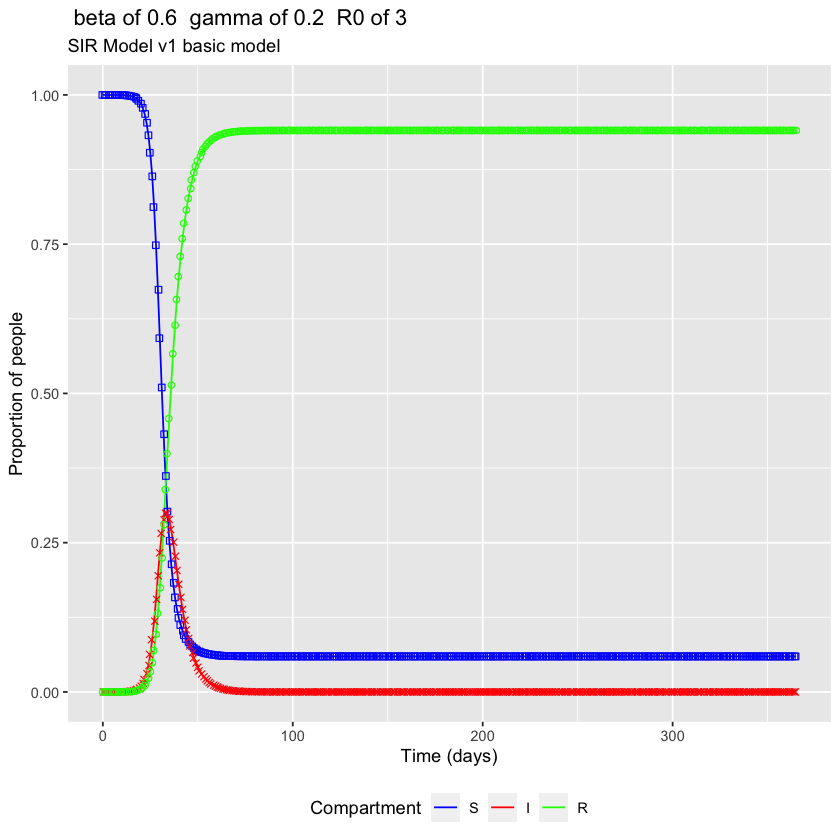

In [21]:
output %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green")) + 
  scale_shape_manual(values = c(0,4,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

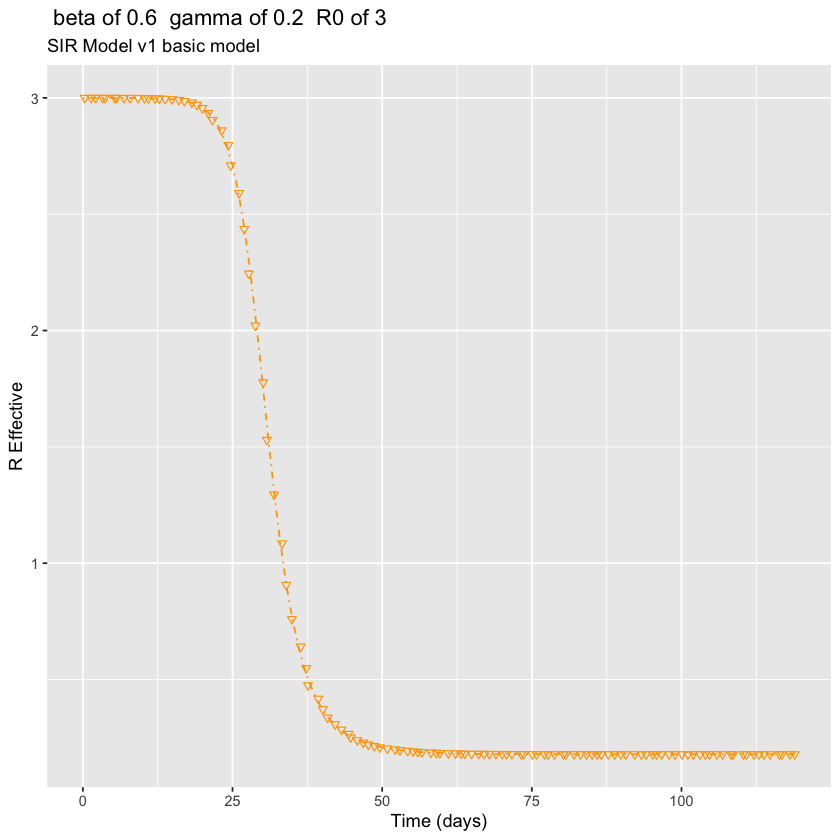

In [18]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

Additional infectious people in the T compartment:

$λ=βI+TN$

Or another way of expressing this:

$λ=βIN+βTN$

Check the impact that treatment has on the course of this epidemic. .

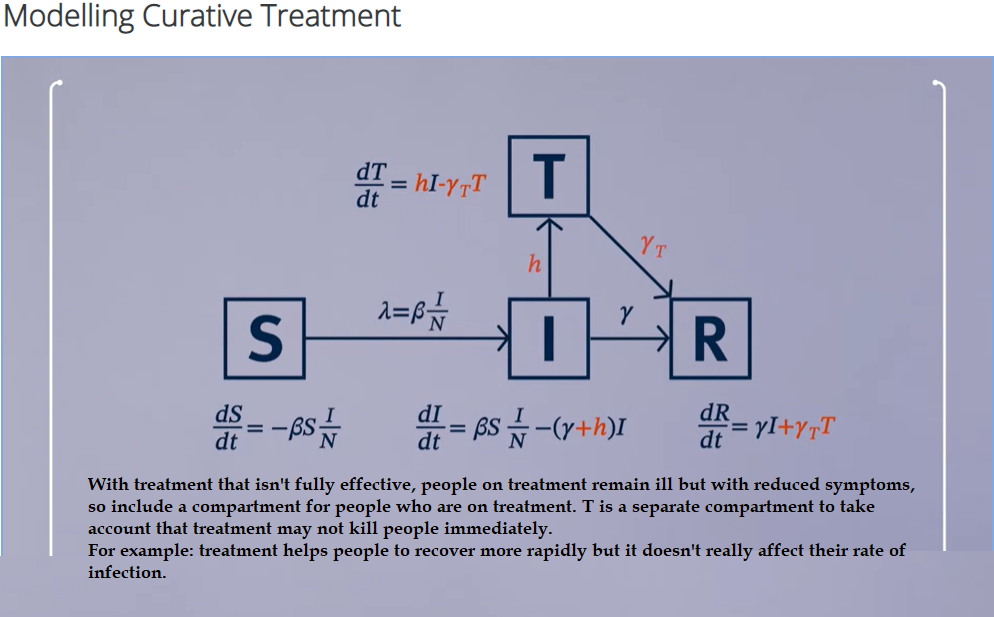

In [50]:
nicesubtitle <- "SIR Model v2a with untreated I and treated T infected"
print(nicesubtitle)

[1] "SIR Model v2a with untreated I and treated T infected"


In [51]:
print("initial state values and parameters")

[1] "initial state values and parameters"


In [52]:
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 365            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
beta     <- 0.6            # infection rate given as 1 day^-1
gamma    <- 1/5            # recover after 5 days for untreated I
gammaT   <- 1/1.25         # recover after 1.25 days for treated T
h        <- 1/4            # rate of transition from I to T 
R0 <- beta / gamma

(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  gammaT = gammaT,      # recovery rate for treated T
  h = h,                # rate of transition from I to T
  R0 = R0
  ))  

beta  gamma gammaT      h     R0 
  0.60   0.20   0.80   0.25   3.00

In [53]:
initial_state_values <- c(S = N-1,
                          I = 1, 
                          T = 0, 
                           R = 0)
# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c2a <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + T + R
      lambda <- beta * (I + T)/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -((gamma + h) * I)
      dT <- (h * I) -(gammaT * T)
      dR <- (gamma * I) + (gammaT * T)
      return(list(c(dS, dI, dT, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c2a,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + T + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + T + R),digits=5)*100,
    in_Treated = round(T/(S+ I + T + R),digits=5)*100,
    propor_Re = round(R/(S + I + T + R),digits=5)*100,
    combo_I_T = round((I+T),digits=1),
    perc_I_T = round((I+T)/(S + I + T + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + T + R)) ) 


####  Check people are infected at the peak of the epidemic
There were 37,615 (12.5%) infected at the peak on day 42

In [54]:
print("peak infection day when I is at its max")
output %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max"


time S        I        T        R        still_Su preval_Inf in_Treated
1 42   169285.2 28881.29 8733.865 93099.67 56.428   9.627      2.911     
  propor_Re combo_I_T perc_I_T Reff    
1 31.033    37615.2   12.538   1.692852

In [55]:
print("peak infection & treated days when (I + T) is at its max: ")
##"peak infection & treated days when (I + T) is at its max: "
output %>%
  arrange(-(I+T), time) %>%
  head(1)

[1] "peak infection & treated days when (I + T) is at its max: "


time S        I        T        R        still_Su preval_Inf in_Treated
1 42   169285.2 28881.29 8733.865 93099.67 56.428   9.627      2.911     
  propor_Re combo_I_T perc_I_T Reff    
1 31.033    37615.2   12.538   1.692852

In [56]:
print("point when R eff goes below 1: ")
## "point when R eff goes below 1: "
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S        I        T        R      still_Su preval_Inf in_Treated
1 52   99060.75 9410.079 3683.139 187846 33.02    3.137      1.228     
  propor_Re combo_I_T perc_I_T Reff     
1 62.615    13093.2   4.364    0.9906075

In [57]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)


[1] "last record for the run: "


time S        I            T            R      still_Su preval_Inf
366 365  86189.98 4.096914e-23 1.721887e-23 213810 28.73    0         
    in_Treated propor_Re combo_I_T perc_I_T Reff     
366 0          71.27     0         0        0.8618998

[1] "Plotting the proportion of people in each compartment over time"


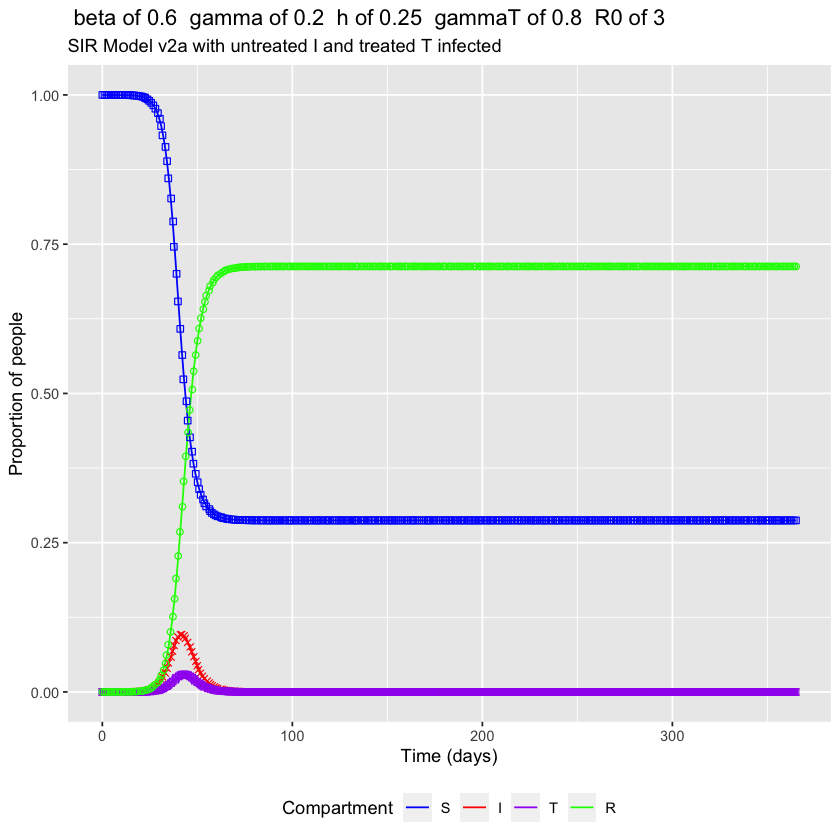

In [58]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -in_Treated, -propor_Re, -Reff,
    -combo_I_T, -perc_I_T) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","purple","green")) + 
  scale_shape_manual(values = c(0,4,7,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " h of", parameters['h'],
    " gammaT of", parameters['gammaT'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

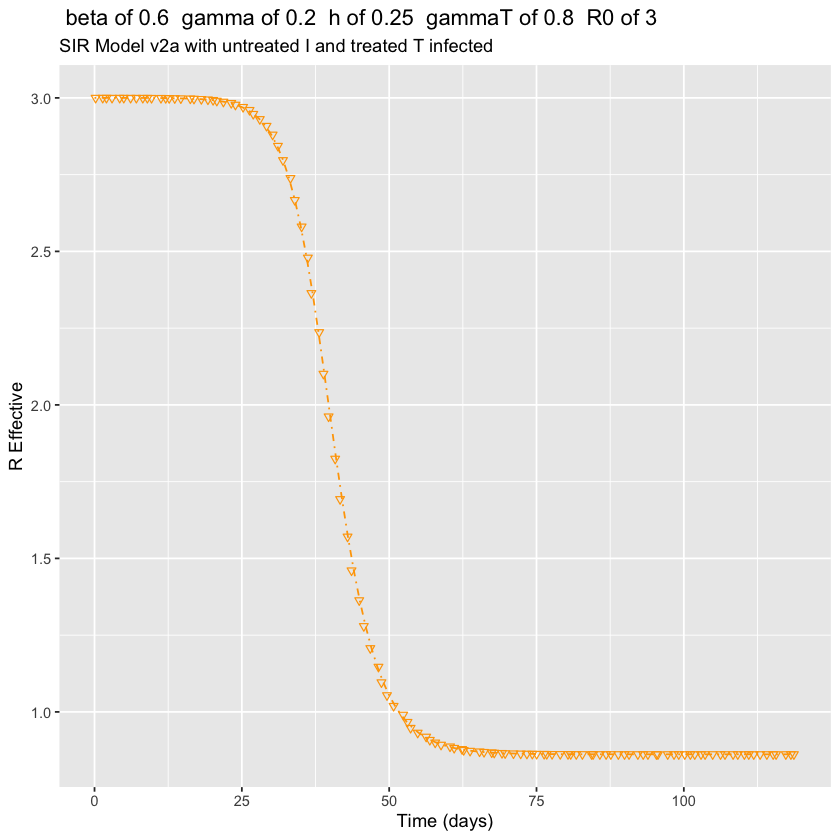

In [59]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " h of", parameters['h'],
    " gammaT of", parameters['gammaT'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

Despite the treatment, an epidemic still occurs, albeit a smaller one than if no one was treated.
How you could improve the impact of this treatment on reducing the prevalence of this infection, by changing the treatment initiation rate?

Changing the transition rate from 1/4 to 1 (treat everyone after 1 day) reduces peak infected (I + T) to 2,362 (0.8%), pushing out to day 111. Although we have no infected after 365 days, We still need to bump up the transition rate to treatment (h) such that there is no epidemic.


In [60]:
nicesubtitle <- "SIR Model v2a2 with untreated I and treated T infected"


In [61]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 365            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
beta     <- 0.6            # infection rate given as 1 day^-1
gamma    <- 1/5            # recover after 5 days for untreated I
gammaT   <- 1/1.25         # recover after 1.25 days for treated T
h        <- 1              # rate of transition from I to T 
R0 <- beta / gamma

(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  gammaT = gammaT,      # recovery rate for treated T
  h = h,                # rate of transition from I to T
  R0 = R0
  ))

[1] "initial state values and parameters"


beta  gamma gammaT      h     R0 
   0.6    0.2    0.8    1.0    3.0

In [62]:
initial_state_values <- c(S = N-1,
                          I = 1, 
                          T = 0, 
                          R = 0)
# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c2a <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + T + R
      lambda <- beta * (I + T)/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -((gamma + h) * I)
      dT <- (h * I) -(gammaT * T)
      dR <- (gamma * I) + (gammaT * T)
      return(list(c(dS, dI, dT, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c2a,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + T + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + T + R),digits=5)*100,
    in_Treated = round(T/(S+ I + T + R),digits=5)*100,
    propor_Re = round(R/(S + I + T + R),digits=5)*100,
    combo_I_T = round((I+T),digits=1),
    perc_I_T = round((I+T)/(S + I + T + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + T + R)) ) 
  

In [63]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S        I        T        R        still_Su preval_Inf in_Treated
1 110  267997.9 1051.608 1305.755 29644.78 89.333   0.351      0.435     
  propor_Re combo_I_T perc_I_T Reff    
1 9.882     2357.4    0.786    2.679979

In [64]:
print("peak infection & treated days when (I + T) is at its max: ")
output %>%
  arrange(-(I+T), time) %>%
  head(1)

[1] "peak infection & treated days when (I + T) is at its max: "


time S        I       T       R        still_Su preval_Inf in_Treated
1 111  266735.6 1051.58 1310.75 30902.02 88.912   0.351      0.437     
  propor_Re combo_I_T perc_I_T Reff    
1 10.301    2362.3    0.787    2.667356

In [65]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S I T R still_Su preval_Inf in_Treated propor_Re combo_I_T perc_I_T
     Reff

In [66]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I            T           R        still_Su preval_Inf
366 365  235892.1 1.477466e-05 2.04156e-05 64107.89 78.631   0         
    in_Treated propor_Re combo_I_T perc_I_T Reff    
366 0          21.369    0         0        2.358921

[1] "Plotting the proportion of people in each compartment over time"


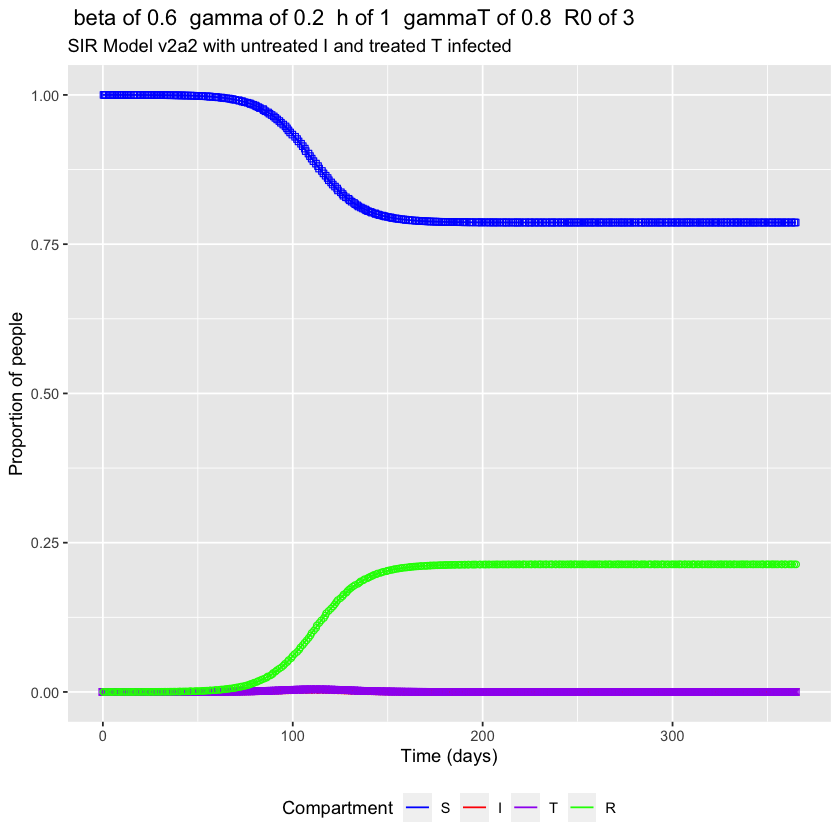

In [67]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -in_Treated, -propor_Re, -Reff,
    -combo_I_T, -perc_I_T) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","purple","green")) + 
  scale_shape_manual(values = c(0,4,7,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " h of", parameters['h'],
    " gammaT of", parameters['gammaT'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

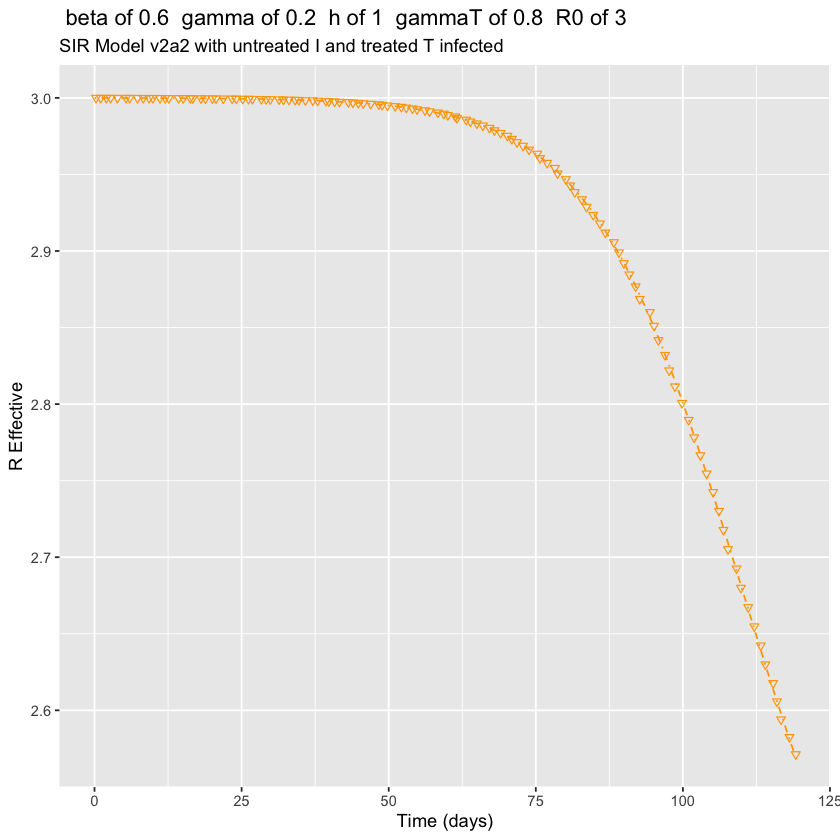

In [68]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " h of", parameters['h'],
    " gammaT of", parameters['gammaT'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

In [69]:
nicesubtitle <- "SIR Model v2a3 with untreated I and treated T infected"

In [70]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 365            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
beta     <- 0.6            # infection rate given as 1 day^-1
gamma    <- 1/5            # recover after 5 days for untreated I
gammaT   <- 1/1.25         # recover after 1.25 days for treated T
h        <- 1.6            # rate of transition from I to T 
R0 <- beta / gamma

(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  gammaT = gammaT,      # recovery rate for treated T
  h = h,                # rate of transition from I to T
  R0 = R0
  ))  

[1] "initial state values and parameters"


beta  gamma gammaT      h     R0 
   0.6    0.2    0.8    1.6    3.0

In [52]:
initial_state_values <- c(S = N-1,
                          I = 1, 
                          T = 0, 
                          R = 0)
# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c2a <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + T + R
      lambda <- beta * (I + T)/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -((gamma + h) * I)
      dT <- (h * I) -(gammaT * T)
      dR <- (gamma * I) + (gammaT * T)
      return(list(c(dS, dI, dT, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c2a,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + T + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + T + R),digits=5)*100,
    in_Treated = round(T/(S+ I + T + R),digits=5)*100,
    propor_Re = round(R/(S + I + T + R),digits=5)*100,
    combo_I_T = round((I+T),digits=1),
    perc_I_T = round((I+T)/(S + I + T + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + T + R)) ) 

In [53]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(-I, time) %>%
  head(1)


[1] "peak infection day when I is at its max: "


time S      I T R still_Su preval_Inf in_Treated propor_Re combo_I_T perc_I_T
1 0    299999 1 0 0 100      0          0          0         1         0       
  Reff   
1 2.99999

In [55]:
print("peak infection & treated days when (I + T) is at its max: ")
output %>%
  arrange(-(I+T), time) %>%
  head(1)

[1] "peak infection & treated days when (I + T) is at its max: "


time S        I         T         R        still_Su preval_Inf in_Treated
1 5    299995.5 0.4000112 0.7999415 3.339973 99.998   0          0         
  propor_Re combo_I_T perc_I_T Reff    
1 0.001     1.2       0        2.999955

In [56]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S I T R still_Su preval_Inf in_Treated propor_Re combo_I_T perc_I_T
     Reff

In [57]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I         T         R        still_Su preval_Inf in_Treated
366 365  299746.1 0.3568364 0.7142162 252.8295 99.915   0          0         
    propor_Re combo_I_T perc_I_T Reff    
366 0.084     1.1       0        2.997461

[1] "Plotting the proportion of people in each compartment over time"


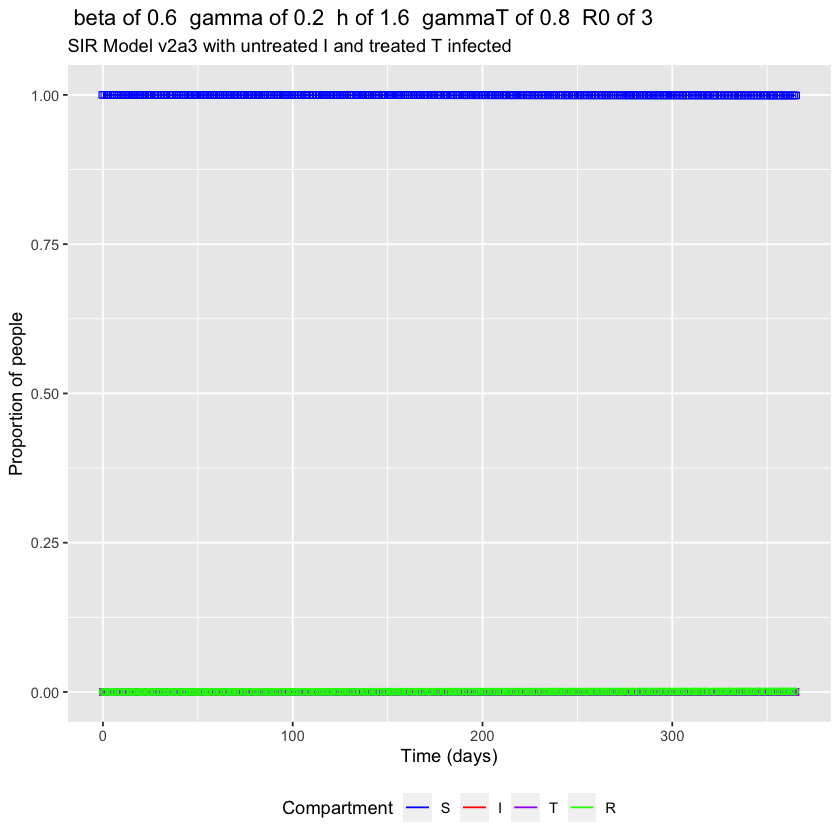

In [58]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -in_Treated, -propor_Re, -Reff,
    -combo_I_T, -perc_I_T) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","purple","green")) + 
  scale_shape_manual(values = c(0,4,7,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " h of", parameters['h'],
    " gammaT of", parameters['gammaT'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

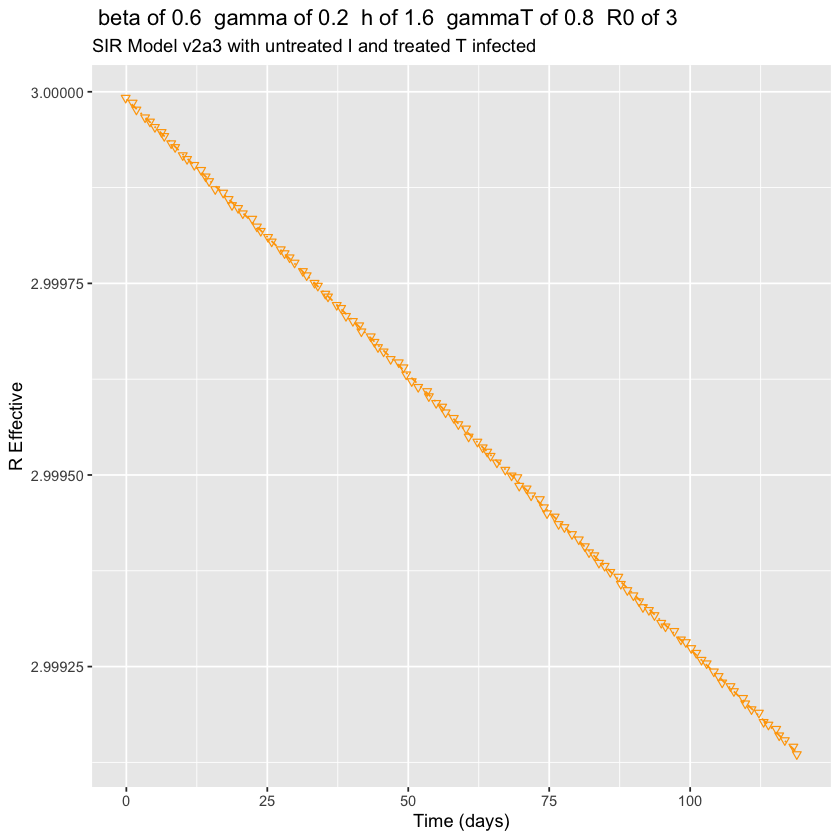

In [59]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " h of", parameters['h'],
    " gammaT of", parameters['gammaT'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

#### ) changes to  make to treatment to improve its impact on the epidemic

**A separate compartment for vaccination**
Develop a simple model of vaccination that you can modify to explore different ways of modelling vaccine impact. 
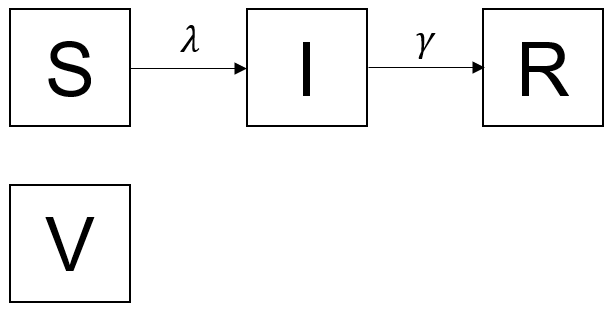

\begin{align}
S0 & = (1-p) N \\
I0 & = 1 \\
R0 & = 0 \\
V0 & = p N
\end{align}


In [60]:
nicesubtitle <- "SIR Model v3a with separate V vaccinated"

In [61]:
print("initial state values and parameters")
## [1] "initial state values and parameters"
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 120            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
beta     <- 0.6            # infection rate given as 1 day^-1
gamma    <- 1/5            # recover after 5 days for untreated I
pvacc    <- .10            # vaccination coverage aka p 
R0 <- beta / gamma
pvacc_thresh <- 1 - (1/R0)

(parameters <- c(
  beta = beta, 
  gamma = gamma, 
  R0 = R0, 
  pvacc = pvacc, 
  pvacc_thresh = pvacc_thresh
  ))

[1] "initial state values and parameters"


beta        gamma           R0        pvacc pvacc_thresh 
   0.6000000    0.2000000    3.0000000    0.1000000    0.6666667

In [62]:
initial_state_values <- c(S = round((N-1) * (1-pvacc)),
                          I = 1, 
                          R = 0, 
                          V = round((N-1) * (pvacc)) )

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c3a <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R + V
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      dV <- 0  # V stays the same over time, 
               # so rate of change equals 0
      return(list(c(dS, dI, dR, dV)))
      })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c3a,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R + V),digits=5)*100,
    preval_Inf = round(I/(S+ I + R + V),digits=5)*100,
    propor_Re = round(R/(S + I + R + V),digits=5)*100,
    propor_Vac = round(V/(S + I + R + V),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R + V)) ) 

In [63]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S        I        R        V     still_Su preval_Inf propor_Re
1 38   106655.7 70463.08 92881.21 30000 35.552   23.488     30.96    
  propor_Vac Reff    
1 10         1.066557

In [64]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S        I        R        V     still_Su preval_Inf propor_Re
1 39   92612.54 70388.12 106999.3 30000 30.871   23.463     35.666   
  propor_Vac Reff     
1 10         0.9261254

In [65]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I         R        V     still_Su preval_Inf propor_Re
121 120  22790.05 0.5546693 247209.4 30000 7.597    0          82.403   
    propor_Vac Reff     
121 10         0.2279005

[1] "Plotting the proportion of people in each compartment over time"


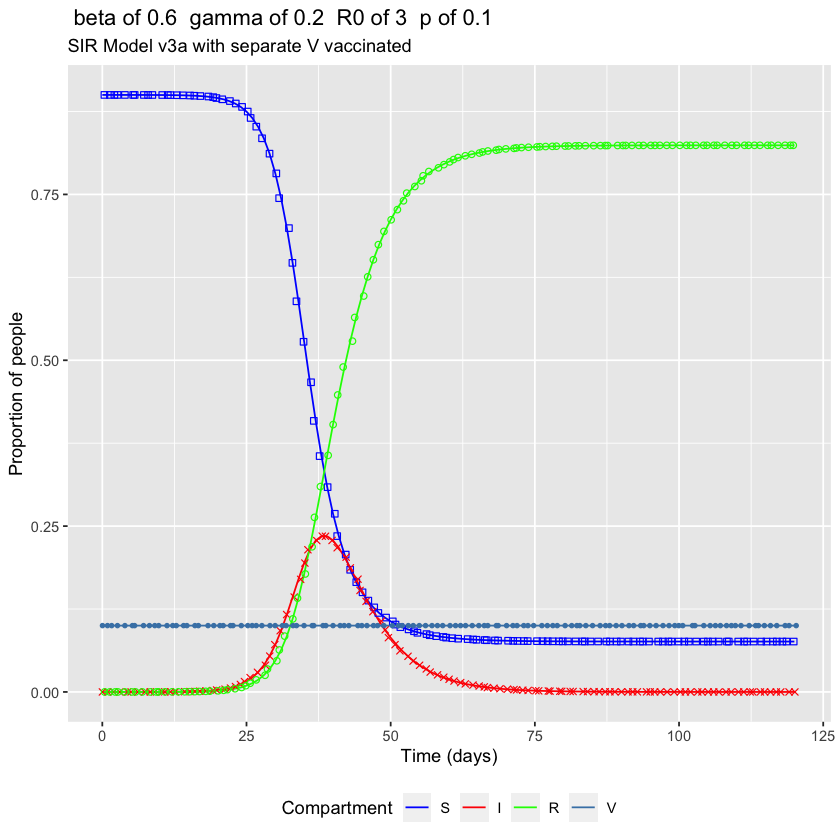

In [66]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -propor_Vac, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green","steelblue")) + 
  scale_shape_manual(values = c(0,4,1,20)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

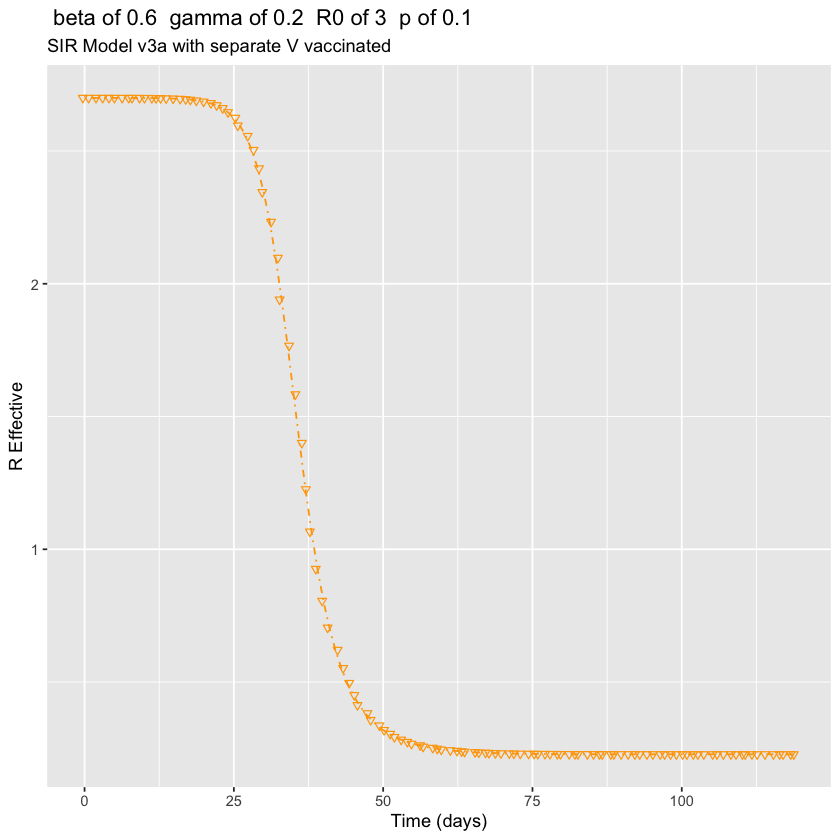

In [67]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

In [ ]:
nicesubtitle <- "SIR Model v3a2 with separate V vaccinated"

In [68]:
print("initial state values and parameters")
## [1] "initial state values and parameters"
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 120            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
beta     <- 0.6            # infection rate given as 1 day^-1
gamma    <- 1/5            # recover after 5 days for untreated I
pvacc    <- .10            # vaccination coverage aka p 
R0 <- beta / gamma
pvacc_thresh <- 1 - (1/R0)
pvacc    <- pvacc_thresh   # set vaccination coverage to cvt
(parameters <- c(
  beta = beta, 
  gamma = gamma, 
  R0 = R0, 
  pvacc = pvacc, 
  pvacc_thresh = pvacc_thresh
  ))

[1] "initial state values and parameters"


beta        gamma           R0        pvacc pvacc_thresh 
   0.6000000    0.2000000    3.0000000    0.6666667    0.6666667

In [69]:
initial_state_values <- c(S = round((N-1) * (1-pvacc)),
                          I = 1, 
                          R = 0, 
                          V = round((N-1) * (pvacc)) )

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c3a <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R + V
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      dV <- 0  # V stays the same over time, 
               # so rate of change equals 0
      return(list(c(dS, dI, dR, dV)))
      })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c3a,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R + V),digits=5)*100,
    preval_Inf = round(I/(S+ I + R + V),digits=5)*100,
    propor_Re = round(R/(S + I + R + V),digits=5)*100,
    propor_Vac = round(V/(S + I + R + V),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R + V)) ) 

In [70]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S     I R V      still_Su preval_Inf propor_Re propor_Vac Reff
1 0    1e+05 1 0 199999 33.333   0          0         66.666     1

In [71]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S     I R V      still_Su preval_Inf propor_Re propor_Vac Reff
1 0    1e+05 1 0 199999 33.333   0          0         66.666     1

In [72]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I         R        V      still_Su preval_Inf propor_Re
121 120  99976.03 0.9971257 23.97699 199999 33.325   0          0.008    
    propor_Vac Reff     
121 66.666     0.9997603

[1] "Plotting the proportion of people in each compartment over time"


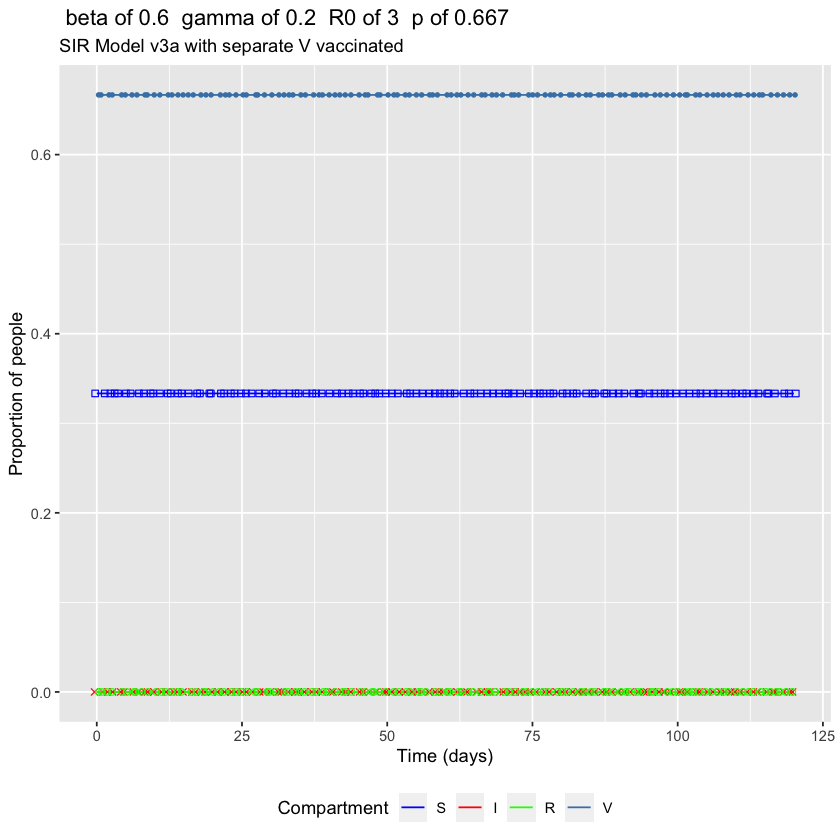

In [73]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -propor_Vac, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green","steelblue")) + 
  scale_shape_manual(values = c(0,4,1,20)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

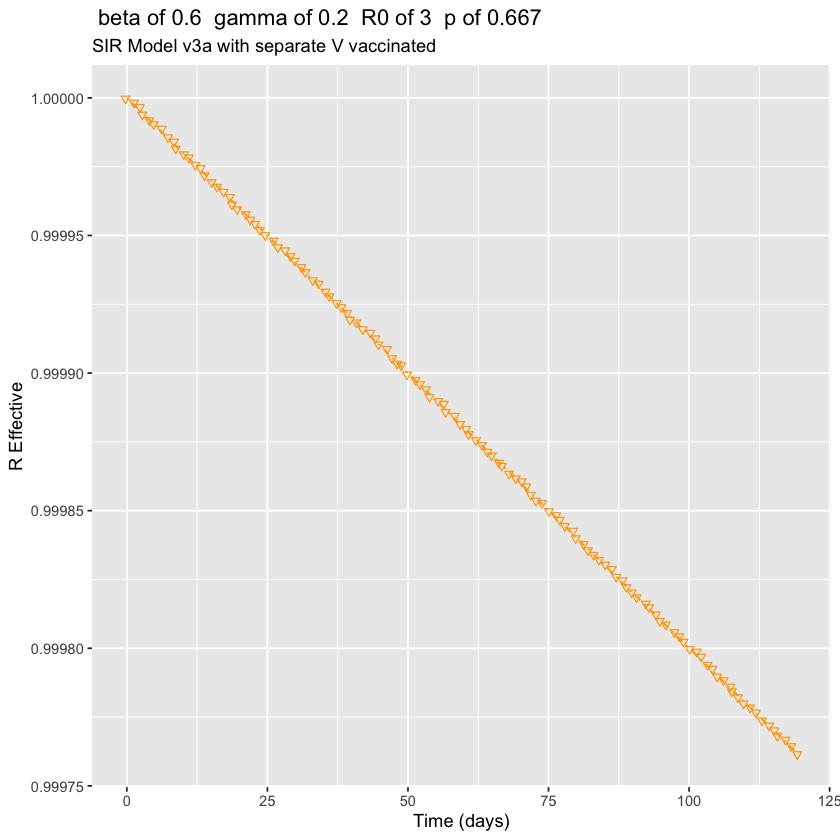

In [74]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

### Modelling a leaky vaccine
We will continue working on the model that assumed that a proportion p of the population received a vaccine that is fully effective in protecting against infection.

#### Question: Assuming β equals 0.25 days−1 and γ equals 0.1 days−1, what proportion of the population would have to be vaccinated with a perfectly effective vaccine to prevent an epidemic?
It appears that pvacc p should be set to the pvacc_thresh pc critical vaccination threshold of 0.60 to avoid an epidemic.
Using the formula for the herd immunity threshold, we need a vaccine coverage of 60% with a perfect vaccine:
\begin{align}
p_c & = 1- \frac{1}{R_{0}} \\
    & = 1- \frac{\gamma}{\beta} \\
    & = 1 - \frac{0.1}{0.25} \\
    & = 0.6
\end{align}

In [75]:
nicesubtitle <- "SIR Model v3a3 with perfectly eff vaccine"


In [76]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 720            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
beta     <- 0.25           # infection rate given as 1 day^-1
gamma    <- 0.1            # recover after 5 days for untreated I
pvacc    <- .10            # vaccination coverage aka p 
R0 <- beta / gamma
pvacc_thresh <- 1 - (1/R0)
pvacc    <- pvacc_thresh   # set vaccination coverage to cvt
(parameters <- c(
  beta = beta, 
  gamma = gamma, 
  R0 = R0, 
  pvacc = pvacc, 
  pvacc_thresh = pvacc_thresh
  ))


[1] "initial state values and parameters"


beta        gamma           R0        pvacc pvacc_thresh 
        0.25         0.10         2.50         0.60         0.60

In [79]:
initial_state_values <- c(S = round((N-1) * (1-pvacc)),
                          I = 1, 
                          R = 0, 
                          V = round((N-1) * (pvacc)) )

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c3a <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R + V
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      dV <- 0  # V stays the same over time, 
               # so rate of change equals 0
      return(list(c(dS, dI, dR, dV)))
      })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c3a,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R + V),digits=5)*100,
    preval_Inf = round(I/(S+ I + R + V),digits=5)*100,
    propor_Re = round(R/(S + I + R + V),digits=5)*100,
    propor_Vac = round(V/(S + I + R + V),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R + V)) ) 

In [80]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S      I R V      still_Su preval_Inf propor_Re propor_Vac Reff
1 0    120000 1 0 179999 40       0          0         60         1

In [81]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S        I R   V      still_Su preval_Inf propor_Re propor_Vac Reff     
1 1    119999.9 1 0.1 179999 40       0          0         60         0.9999992

In [82]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I         R        V      still_Su preval_Inf propor_Re
721 720  119928.5 0.9787115 71.48612 179999 39.976   0          0.024    
    propor_Vac Reff     
721 60         0.9994045

[1] "Plotting the proportion of people in each compartment over time"


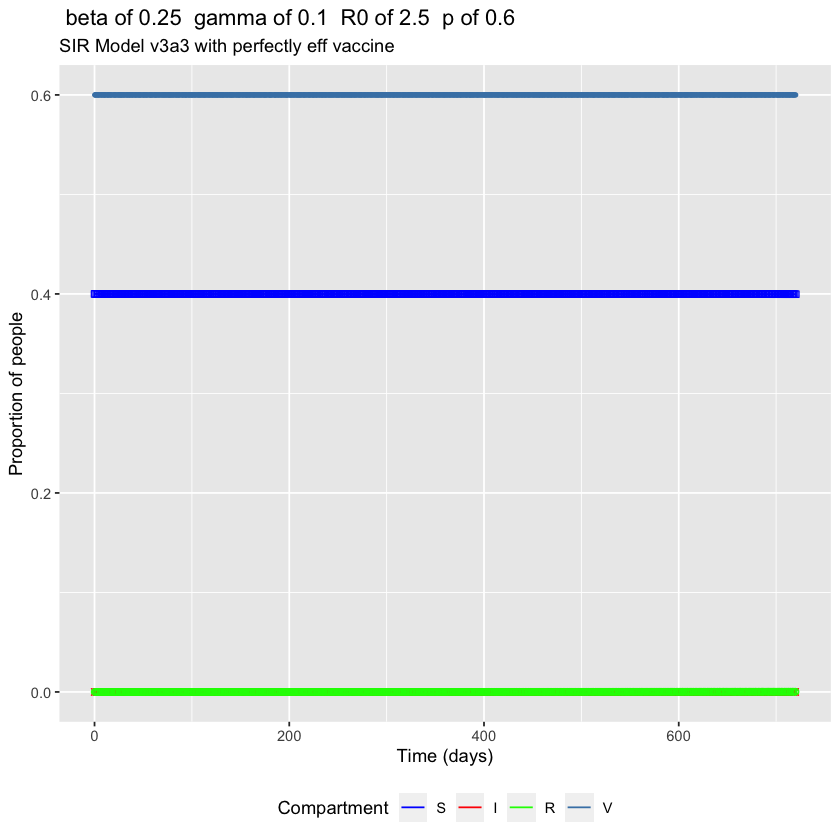

In [83]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -propor_Vac, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green","steelblue")) + 
  scale_shape_manual(values = c(0,4,1,20)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

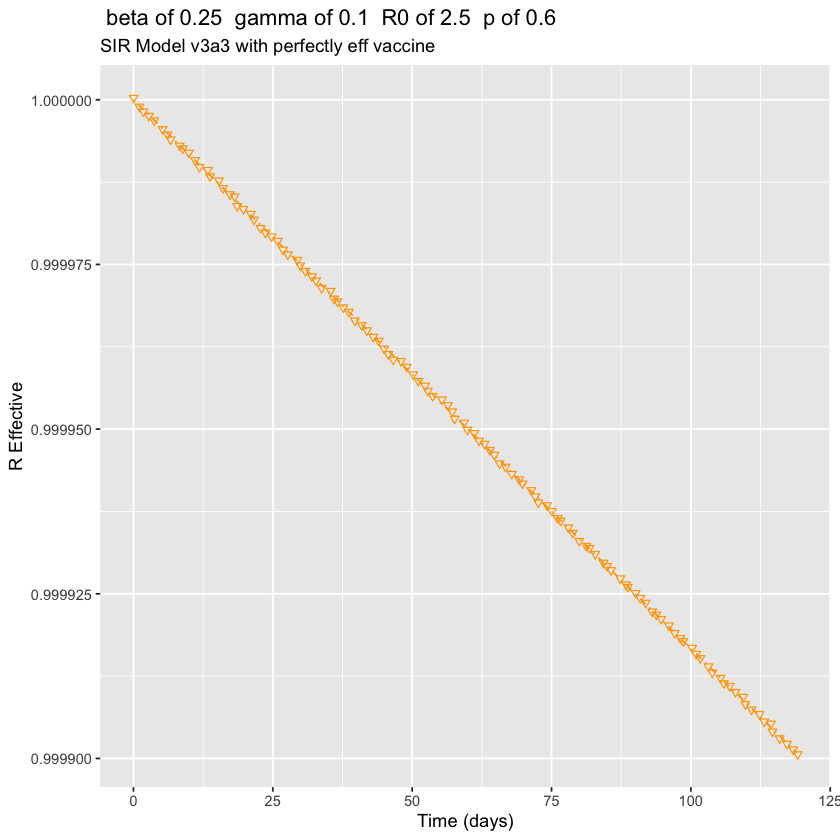

In [84]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

 All-or-nothing vaccines give full immunity to a proportion of those vaccinated, but don’t work at all in the other vaccinated people.

leaky vaccines reduce susceptibility in everyone who received the vaccine by the same fraction. This means that vaccinated people can still become infected, but at a reduced rate (force of infection), like so
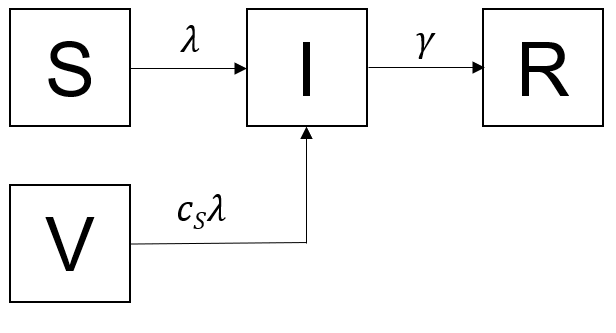

Question: Based on the diagram, write out the differential equations for this model. What is the value of cS for a leaky vaccine with 70% efficacy?
\begin{align}
\frac{dS}{dt} & = -\beta \frac{I}{N} S \\
\frac{dI}{dt} & = \beta \frac{I}{N} S + c_{s} \beta \frac{I}{N} V - \gamma I \\
\frac{dR}{dt} & = \gamma I \\
\frac{dV}{dt} & = -c_{s} \beta \frac{I}{N} V
\end{align}



In [2]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 720            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
veff     <- .70            # vaccine efficacy
cs       <- 1 - veff      # reduction in the force of infection (1 - % eff)
beta     <- 0.25           # infection rate given as 1 day^-1
gamma    <- 0.1            # recovery rate given as 1 day^-1
pvacc    <- .60            # vaccination coverage aka p 
R0 <- beta / gamma

pvacc_thresh <- 1 - (1/R0) # threshold for vaccine 100% efficacy
# pvacc    <- pvacc_thresh   # set vaccination coverage to cvt
peff     <- pvacc * veff   # effective vaccine coverage
pvacc_thresh <- (1 - (1/R0))/veff # recalc results to consider efficacy
# pvacc    <- pvacc_thresh   # set vaccination coverage to recalc cvt

(parameters <- c(
  veff = veff,
  peff = peff,
  cs   = cs, 
  beta = beta, 
  gamma = gamma, 
  R0 = R0, 
  pvacc = pvacc, 
  pvacc_thresh = pvacc_thresh
  ))

[1] "initial state values and parameters"


veff         peff           cs         beta        gamma           R0 
   0.7000000    0.4200000    0.3000000    0.2500000    0.1000000    2.5000000 
       pvacc pvacc_thresh 
   0.6000000    0.8571429

In [3]:
initial_state_values <- c(S = round((N-1) * (1-pvacc)),
                          I = 1, 
                          R = 0, 
                          V = round((N-1) * (pvacc)) )

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c4a <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R + V
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I) +(cs * (lambda * V))
      dR <- (gamma * I)
      dV <- -(cs * (lambda * V))  # leaky vacc only 70% eff 
      return(list(c(dS, dI, dR, dV)))
      })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c4a,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R + V),digits=5)*100,
    preval_Inf = round(I/(S+ I + R + V),digits=5)*100,
    propor_Re = round(R/(S + I + R + V),digits=5)*100,
    propor_Vac = round(V/(S + I + R + V),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R + V)) ) 

ERROR: Error in as.data.frame(ode(y = initial_state_values, times = times, func = sir_model_c4a, : could not find function "%>%"


In [91]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S        I        R        V        still_Su preval_Inf propor_Re
1 245  73334.63 12292.84 59095.06 155277.5 24.445   4.098      19.698   
  propor_Vac Reff     
1 51.759     0.6111219

In [1]:
nicesubtitle <- "SIR Model v4a1 leaky vaccine w/ 70% efficacy"


In [92]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S        I        R         V      still_Su preval_Inf propor_Re
1 1    119999.9 1.046028 0.1022851 179999 40       0          0        
  propor_Vac Reff     
1 60         0.9999991

In [95]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I           R        V        still_Su preval_Inf propor_Re
721 720  41303.23 0.006452345 127986.1 130710.6 13.768   0          42.662   
    propor_Vac Reff     
721 43.57      0.3441935

[1] "Plotting the proportion of people in each compartment over time"


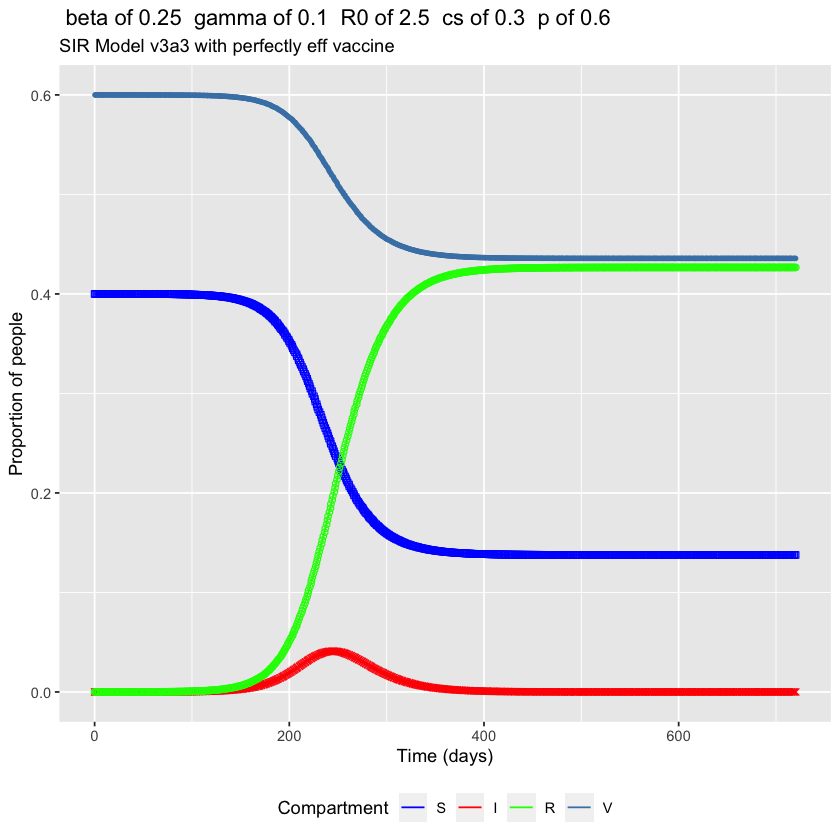

In [96]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -propor_Vac, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green","steelblue")) + 
  scale_shape_manual(values = c(0,4,1,20)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

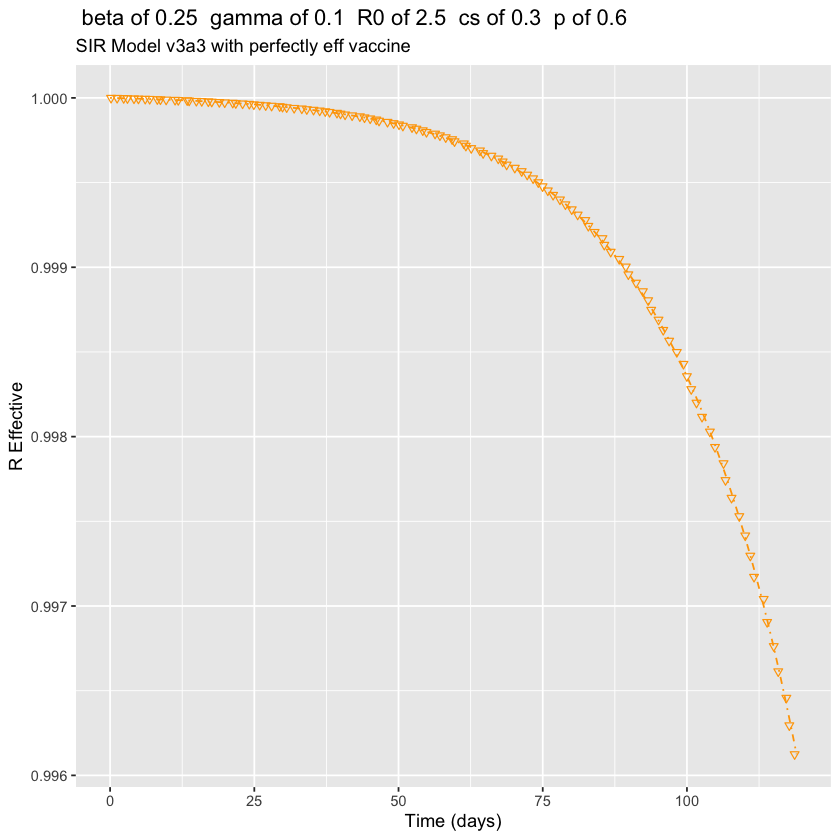

In [97]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

Using critical vaccination threshold calculated with vaccination efficacy of 70% prevents an epidemic:


In [98]:
nicesubtitle <- "SIR Model v4a2 leaky vaccine w/ 70% efficacy"

In [100]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 300000         # population size
duration <- 720            # total number of days
tsteps   <- 1              # chunk into 1 day intervals 
veff     <- .70            # vaccine efficacy
cs       <- 1 - veff      # reduction in the force of infection (1 - % eff)
beta     <- 0.25           # infection rate given as 1 day^-1
gamma    <- 0.1            # recovery rate given as 1 day^-1
pvacc    <- .60            # vaccination coverage aka p 
R0 <- beta / gamma

pvacc_thresh <- 1 - (1/R0) # threshold for vaccine 100% efficacy
# pvacc    <- pvacc_thresh   # set vaccination coverage to cvt
peff     <- pvacc * veff   # effective vaccine coverage
pvacc_thresh <- (1 - (1/R0))/veff # recalc results to consider efficacy
pvacc    <- pvacc_thresh   # set vaccination coverage to recalc cvt

(parameters <- c(
  veff = veff,
  peff = peff,
  cs   = cs, 
  beta = beta, 
  gamma = gamma, 
  R0 = R0, 
  pvacc = pvacc, 
  pvacc_thresh = pvacc_thresh
  ))

[1] "initial state values and parameters"


veff         peff           cs         beta        gamma           R0 
   0.7000000    0.4200000    0.3000000    0.2500000    0.1000000    2.5000000 
       pvacc pvacc_thresh 
   0.8571429    0.8571429

In [101]:
initial_state_values <- c(S = round((N-1) * (1-pvacc)),
                          I = 1, 
                          R = 0, 
                          V = round((N-1) * (pvacc)) )

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c4a <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R + V
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I) +(cs * (lambda * V))
      dR <- (gamma * I)
      dV <- -(cs * (lambda * V))  # leaky vacc only 70% eff 
      return(list(c(dS, dI, dR, dV)))
      })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c4a,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R + V),digits=5)*100,
    preval_Inf = round(I/(S+ I + R + V),digits=5)*100,
    propor_Re = round(R/(S + I + R + V),digits=5)*100,
    propor_Vac = round(V/(S + I + R + V),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R + V)) ) 

In [102]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S     I R V      still_Su preval_Inf propor_Re propor_Vac Reff     
1 0    42857 1 0 257142 14.286   0          0         85.714     0.3571417

In [103]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S     I R V      still_Su preval_Inf propor_Re propor_Vac Reff     
1 0    42857 1 0 257142 14.286   0          0         85.714     0.3571417

In [105]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S       I         R        V        still_Su preval_Inf propor_Re
721 720  42831.4 0.9879791 71.70769 257095.9 14.277   0          0.024    
    propor_Vac Reff     
721 85.699     0.3569283

[1] "Plotting the proportion of people in each compartment over time"


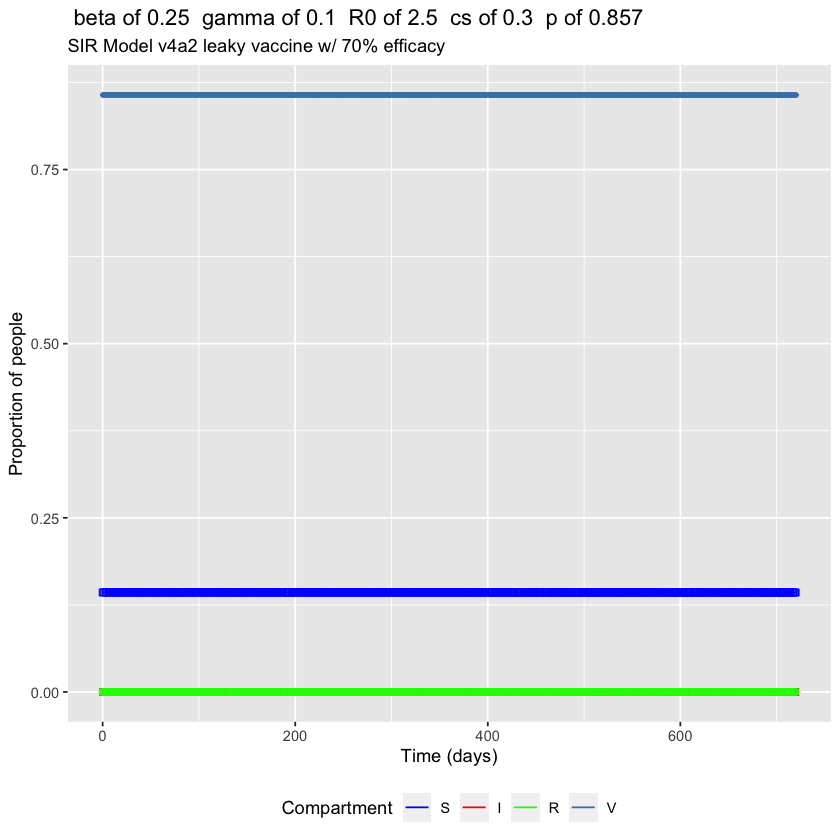

In [106]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -propor_Vac, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green","steelblue")) + 
  scale_shape_manual(values = c(0,4,1,20)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

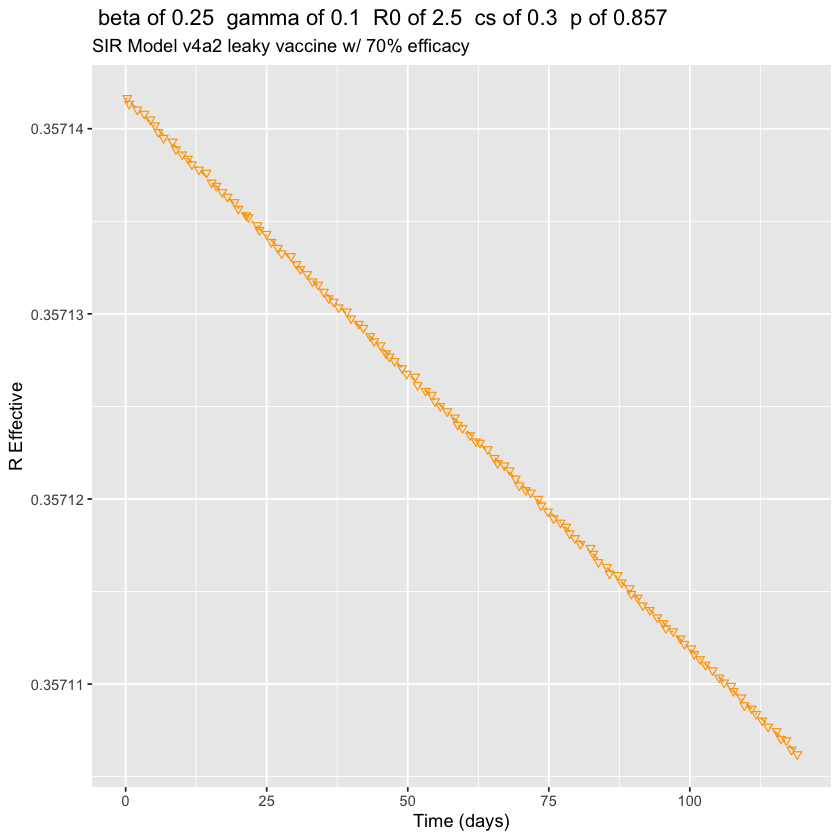

In [107]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

If R(t)<1, it suggests that the epidemic is in decline and may be regarded as being under control at time t (vice versa, if R(t)>1)

In [108]:
nicesubtitle <- "SIR Model v4b1 vaccine w/ combined leaky effects"

In [109]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 1000000      # population size
duration <- 720         # total number of days
tsteps   <- 1            # chunk into 1 day intervals 
cs       <- .3           # reduction in susceptibility  
ci       <- .5           # reduction in infectivity 
veffs    <- (1 - cs)  # vaccine efficacy susceptibility 
veffi    <- (1 - ci)  # vaccine efficacy infectivity 
beta     <- 0.25         # infection rate 1 day^-1
gamma    <- 0.1          # recovery rate 1 day^-1
pvacc    <- .60          # vaccination coverage aka p 
R0 <- beta / gamma

pvacc_thresh <- 1 - (1/R0) # threshold for vaccine 100% efficacy, version 1
# pvacc    <- pvacc_thresh   # set vaccination coverage to cvt
peff     <- pvacc * veff   # effective vaccine coverage
pvacc_thresh <- (1 - (1/R0))/veffs # recalc results to consider efficacy-susceptibility, version 2
pvacc_thresh <- (1 - (1/R0))/(1 - (cs * ci)) # recalc results to consider efficacy-susceptibility & infectivity, version 3
# pvacc    <- pvacc_thresh   # set vaccination coverage to recalc cvt

(parameters <- c(
  peff = peff,
  cs   = cs, 
  ci   = ci, 
  veffs = veffs,
  veffi = veffi,
  beta = beta, 
  gamma = gamma, 
  R0 = R0, 
  pvacc = pvacc, 
  pvacc_thresh = pvacc_thresh
  ))

[1] "initial state values and parameters"


peff           cs           ci        veffs        veffi         beta 
   0.4200000    0.3000000    0.5000000    0.7000000    0.5000000    0.2500000 
       gamma           R0        pvacc pvacc_thresh 
   0.1000000    2.5000000    0.6000000    0.7058824

In [111]:
initial_state_values <- c(S = round((N-1) * (1-pvacc)),
                          I = 1, 
                          Iv = 0, 
                          R = 0, 
                          V = round((N-1) * (pvacc)) )

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c4b <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + Iv + R + V
      lambda <- (beta * I/N) + (ci * beta * Iv/N)
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I) 
      dIv <- (cs * (lambda * V)) -(gamma * Iv) 
      dR <- (gamma * I) +(gamma * Iv) 
      dV <- -(cs * (lambda * V))
      return(list(c(dS, dI, dIv, dR, dV)))
      })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c4b,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + Iv + R + V),digits=5)*100,
    preval_Inf = round(I/(S+ I + Iv + R + V),digits=5)*100,
    preval_InfVac = round(Iv/(S+ I + Iv + R + V),digits=5)*100,
    propor_Re = round(R/(S + I + Iv + R + V),digits=5)*100,
    propor_Vac = round(V/(S + I + Iv + R + V),digits=5)*100,
    count_Inf2 = I+ Iv,
    preval_Inf2 = round((I+ Iv)/(S+ I + Iv + R + V),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + Iv + R + V)) ) 

In [112]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(- (I + Iv), time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S        I        Iv       R        V        still_Su preval_Inf
1 478  314958.3 8079.541 4224.824 114256.2 558481.1 31.496   0.808     
  preval_InfVac propor_Re propor_Vac count_Inf2 preval_Inf2 Reff     
1 0.422         11.426    55.848     12304.36   1.23        0.7873959

In [113]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S        I        Iv         R         V      still_Su preval_Inf
1 1    399999.9 1.001097 0.04331681 0.1022301 599999 40       0         
  preval_InfVac propor_Re propor_Vac count_Inf2 preval_Inf2 Reff     
1 0             0         60         1.044413   0           0.9999997

In [114]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I       Iv       R        V        still_Su preval_Inf
721 720  246230.5 250.938 158.4449 234637.7 518722.5 24.623   0.025     
    preval_InfVac propor_Re propor_Vac count_Inf2 preval_Inf2 Reff     
721 0.016         23.464    51.872     409.3829   0.041       0.6155762

[1] "Plotting the proportion of people in each compartment over time"


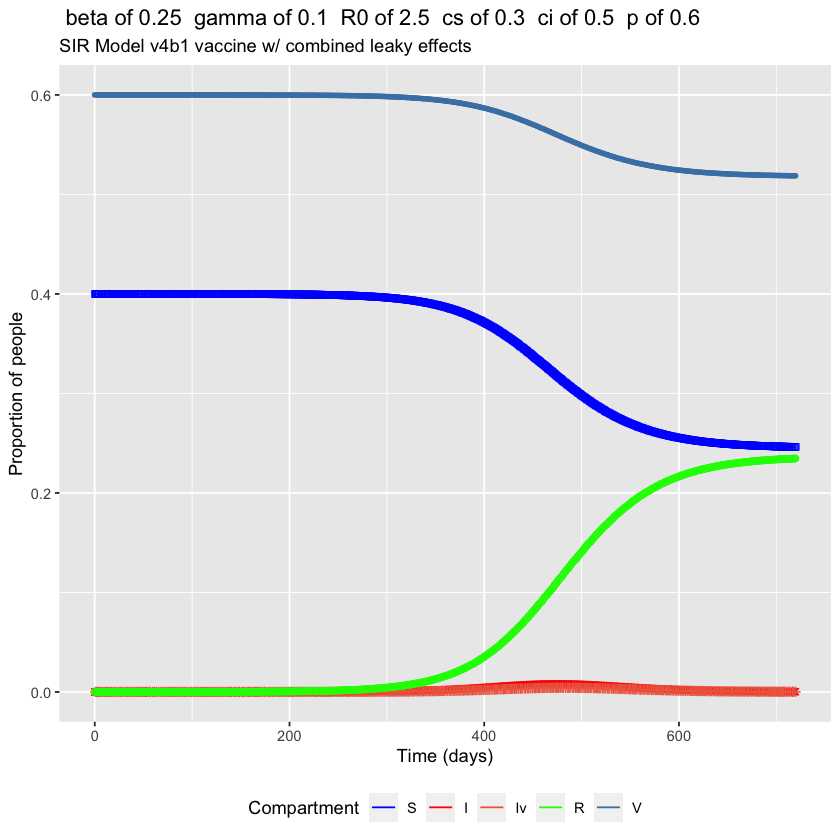

In [115]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -preval_InfVac, -propor_Re, -propor_Vac, -Reff, -count_Inf2, -preval_Inf2) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","coral2", "green","steelblue")) + 
  scale_shape_manual(values = c(0,4,3,1,20)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " ci of", parameters['ci'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

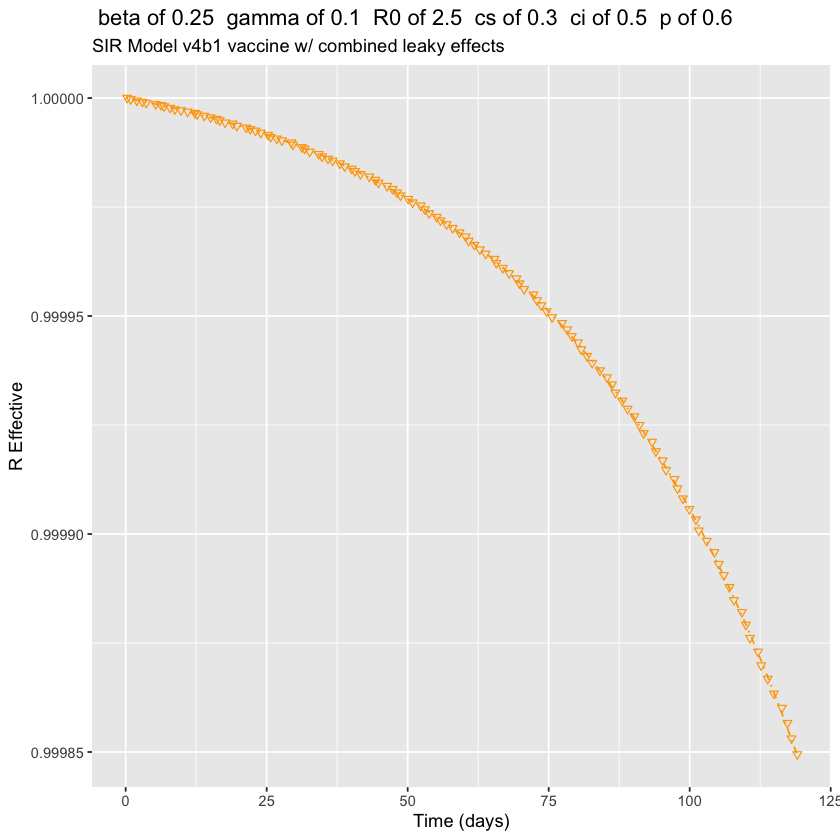

In [116]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " ci of", parameters['ci'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

In [117]:
nicesubtitle <- "SIR Model v4b2 vaccine w/ combined leaky effects"


In [118]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 1000000      # population size
duration <- 720         # total number of days
tsteps   <- 1            # chunk into 1 day intervals 
cs       <- .3           # reduction in susceptibility  
ci       <- .5           # reduction in infectivity 
veffs    <- (1 - cs)  # vaccine efficacy susceptibility 
veffi    <- (1 - ci)  # vaccine efficacy infectivity 
beta     <- 0.25         # infection rate 1 day^-1
gamma    <- 0.1          # recovery rate 1 day^-1
pvacc    <- .60          # vaccination coverage aka p 
R0 <- beta / gamma

pvacc_thresh <- 1 - (1/R0) # threshold for vaccine 100% efficacy, version 1
# pvacc    <- pvacc_thresh   # set vaccination coverage to cvt
peff     <- pvacc * veff   # effective vaccine coverage
pvacc_thresh <- (1 - (1/R0))/veffs # recalc results to consider efficacy-susceptibility, version 2
pvacc_thresh <- (1 - (1/R0))/(1 - (cs * ci)) # recalc results to consider efficacy-susceptibility & infectivity, version 3
pvacc    <- pvacc_thresh   # set vaccination coverage to recalc cvt

(parameters <- c(
  peff = peff,
  cs   = cs, 
  ci   = ci, 
  veffs = veffs,
  veffi = veffi,
  beta = beta, 
  gamma = gamma, 
  R0 = R0, 
  pvacc = pvacc, 
  pvacc_thresh = pvacc_thresh
  ))


[1] "initial state values and parameters"


peff           cs           ci        veffs        veffi         beta 
   0.4200000    0.3000000    0.5000000    0.7000000    0.5000000    0.2500000 
       gamma           R0        pvacc pvacc_thresh 
   0.1000000    2.5000000    0.7058824    0.7058824

In [120]:
initial_state_values <- c(S = round((N-1) * (1-pvacc)),
                          I = 1, 
                          Iv = 0, 
                          R = 0, 
                          V = round((N-1) * (pvacc)) )

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c4b <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + Iv + R + V
      lambda <- (beta * I/N) + (ci * beta * Iv/N)
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I) 
      dIv <- (cs * (lambda * V)) -(gamma * Iv) 
      dR <- (gamma * I) +(gamma * Iv) 
      dV <- -(cs * (lambda * V))
      return(list(c(dS, dI, dIv, dR, dV)))
      })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c4b,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + Iv + R + V),digits=5)*100,
    preval_Inf = round(I/(S+ I + Iv + R + V),digits=5)*100,
    preval_InfVac = round(Iv/(S+ I + Iv + R + V),digits=5)*100,
    propor_Re = round(R/(S + I + Iv + R + V),digits=5)*100,
    propor_Vac = round(V/(S + I + Iv + R + V),digits=5)*100,
    count_Inf2 = I+ Iv,
    preval_Inf2 = round((I+ Iv)/(S+ I + Iv + R + V),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + Iv + R + V)) ) 

In [121]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(- (I + Iv), time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S        I         Iv        R       V        still_Su preval_Inf
1 92   294110.2 0.7352425 0.5293104 11.3702 705877.1 29.411   0         
  preval_InfVac propor_Re propor_Vac count_Inf2 preval_Inf2 Reff     
1 0             0.001     70.588     1.264553   0           0.7352756

In [122]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S      I Iv R V      still_Su preval_Inf preval_InfVac propor_Re
1 0    294117 1 0  0 705882 29.412   0          0             0        
  propor_Vac count_Inf2 preval_Inf2 Reff     
1 70.588     1          0           0.7352925

In [123]:
print("last record for the run: ")
## [1] "last record for the run: "
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I         Iv        R        V      still_Su preval_Inf
721 720  294064.2 0.7313098 0.5266093 90.62938 705844 29.406   0         
    preval_InfVac propor_Re propor_Vac count_Inf2 preval_Inf2 Reff     
721 0             0.009     70.584     1.257919   0           0.7351604

[1] "Plotting the proportion of people in each compartment over time"


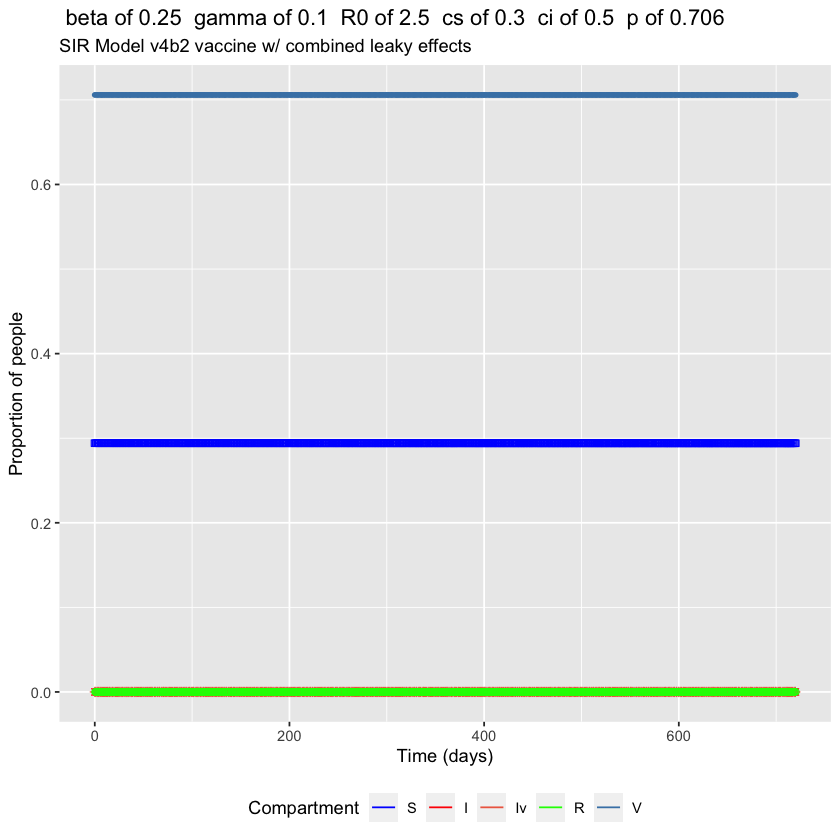

In [124]:
print("Plotting the proportion of people in each compartment over time")
## [1] "Plotting the proportion of people in each compartment over time"
output %>% 
  select(-still_Su, -preval_Inf, -preval_InfVac, -propor_Re, -propor_Vac, -Reff, -count_Inf2, -preval_Inf2) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","coral2", "green","steelblue")) + 
  scale_shape_manual(values = c(0,4,3,1,20)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " ci of", parameters['ci'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

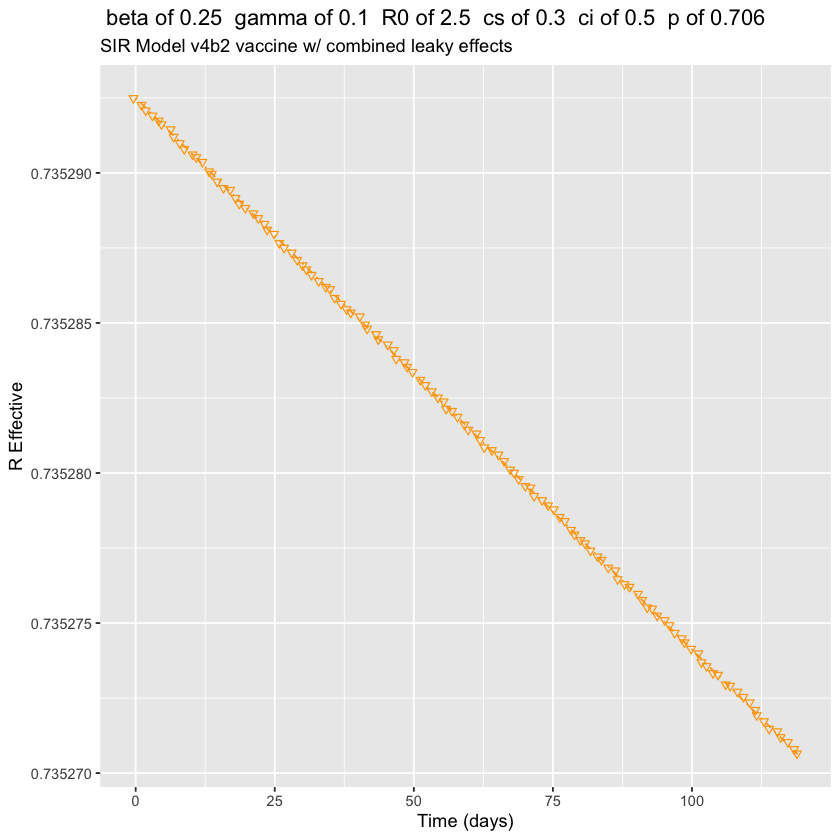

In [125]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " ci of", parameters['ci'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

Using an increased, rounded-up critical vaccination threshold of 0.84 (because last run using calculated cvt had a peak at day 92 with a peak of I + Iv = 1.3, and .84 stops the peak at day 1):

In [126]:
nicesubtitle <- "SIR Model v4b3 vaccine w/ combined leaky effects"


In [127]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 1000000      # population size
duration <- 720          # total number of days
tsteps   <- 1            # chunk into 1 day intervals 
cs       <- .3           # reduction in susceptibility  
ci       <- .5           # reduction in infectivity 
veffs    <- (1 - cs)  # vaccine efficacy susceptibility 
veffi    <- (1 - ci)  # vaccine efficacy infectivity 
beta     <- 0.25         # infection rate 1 day^-1
gamma    <- 0.1          # recovery rate 1 day^-1
pvacc    <- .84           # vaccination coverage aka p 
R0 <- beta / gamma

pvacc_thresh <- 1 - (1/R0) # threshold for vaccine 100% efficacy, version 1
# pvacc    <- pvacc_thresh   # set vaccination coverage to cvt
peff     <- pvacc * veff   # effective vaccine coverage
pvacc_thresh <- (1 - (1/R0))/veffs # recalc results to consider efficacy-susceptibility, version 2
pvacc_thresh <- (1 - (1/R0))/(1 - (cs * ci)) # recalc results to consider efficacy-susceptibility & infectivity, version 3
# pvacc    <- pvacc_thresh   # set vaccination coverage to recalc cvt

(parameters <- c(
  peff = peff,
  cs   = cs, 
  ci   = ci, 
  veffs = veffs,
  veffi = veffi,
  beta = beta, 
  gamma = gamma, 
  R0 = R0, 
  pvacc = pvacc, 
  pvacc_thresh = pvacc_thresh
  ))


[1] "initial state values and parameters"


peff           cs           ci        veffs        veffi         beta 
   0.5880000    0.3000000    0.5000000    0.7000000    0.5000000    0.2500000 
       gamma           R0        pvacc pvacc_thresh 
   0.1000000    2.5000000    0.8400000    0.7058824

In [128]:
initial_state_values <- c(S = round((N-1) * (1-pvacc)),
                          I = 1, 
                          Iv = 0, 
                          R = 0, 
                          V = round((N-1) * (pvacc)) )

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model_c4b <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + Iv + R + V
      lambda <- (beta * I/N) + (ci * beta * Iv/N)
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I) 
      dIv <- (cs * (lambda * V)) -(gamma * Iv) 
      dR <- (gamma * I) +(gamma * Iv) 
      dV <- -(cs * (lambda * V))
      return(list(c(dS, dI, dIv, dR, dV)))
      })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model_c4b,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + Iv + R + V),digits=5)*100,
    preval_Inf = round(I/(S+ I + Iv + R + V),digits=5)*100,
    preval_InfVac = round(Iv/(S+ I + Iv + R + V),digits=5)*100,
    propor_Re = round(R/(S + I + Iv + R + V),digits=5)*100,
    propor_Vac = round(V/(S + I + Iv + R + V),digits=5)*100,
    count_Inf2 = I+ Iv,
    preval_Inf2 = round((I+ Iv)/(S+ I + Iv + R + V),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + Iv + R + V)) )

In [129]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(- (I + Iv), time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S      I         Iv         R         V        still_Su preval_Inf
1 1    160000 0.9423567 0.05909123 0.1000981 839998.9 16       0         
  preval_InfVac propor_Re propor_Vac count_Inf2 preval_Inf2 Reff     
1 0             0         84         1.001448   0           0.3999999

In [130]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)


[1] "point when R eff goes below 1: "


time S      I Iv R V      still_Su preval_Inf preval_InfVac propor_Re
1 0    160000 1 0  0 839999 16       0          0             0        
  propor_Vac count_Inf2 preval_Inf2 Reff
1 84         1          0           0.4

In [131]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S        I            Iv           R        V        still_Su
721 720  159998.6 7.251942e-10 1.142187e-09 4.613991 839996.8 16      
    preval_Inf preval_InfVac propor_Re propor_Vac count_Inf2   preval_Inf2
721 0          0             0         84         1.867381e-09 0          
    Reff     
721 0.3999965

[1] "Plotting the proportion of people in each compartment over time"


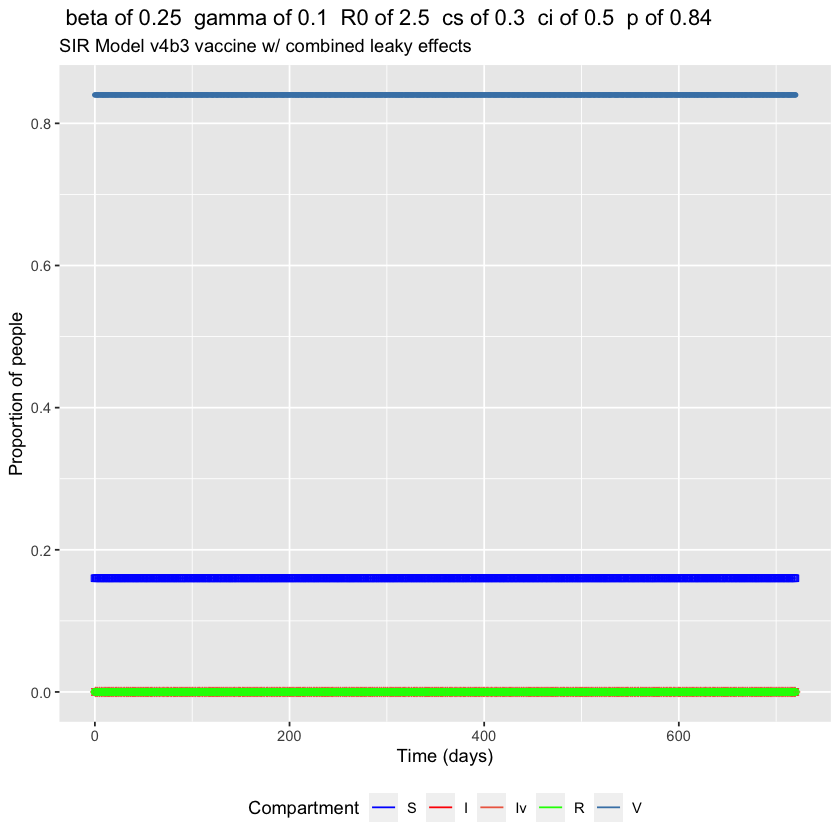

In [132]:

print("Plotting the proportion of people in each compartment over time")
output %>% 
  select(-still_Su, -preval_Inf, -preval_InfVac, -propor_Re, -propor_Vac, -Reff, -count_Inf2, -preval_Inf2) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","coral2", "green","steelblue")) + 
  scale_shape_manual(values = c(0,4,3,1,20)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " ci of", parameters['ci'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

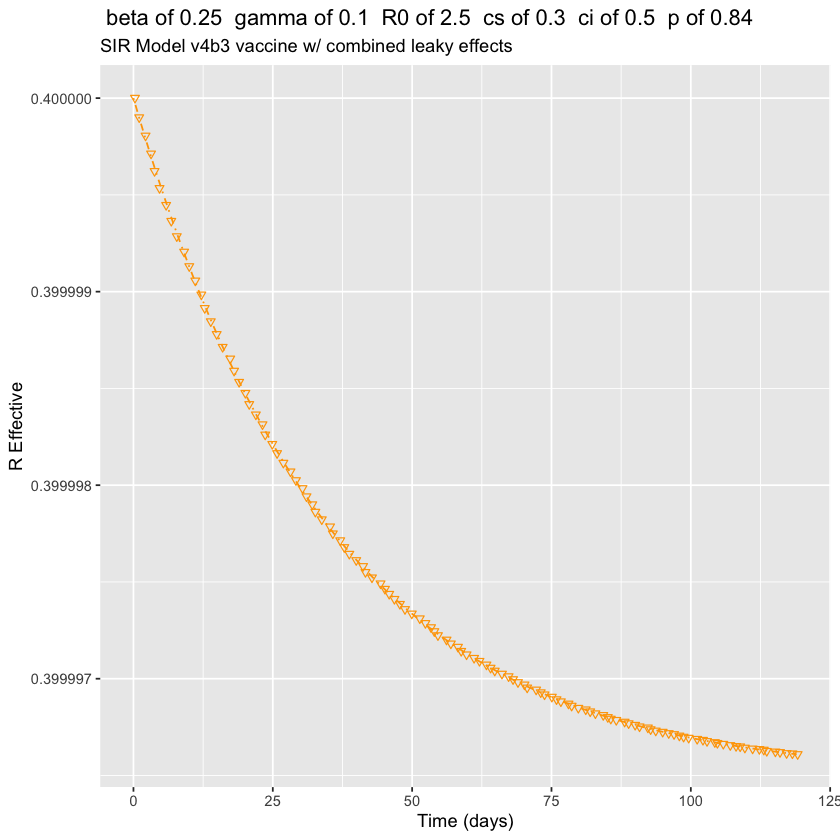

In [133]:
output %>% 
  select(time, Reff) %>% 
  filter(time < 120) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " cs of", parameters['cs'],
    " ci of", parameters['ci'],
    " p of", round(parameters['pvacc'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

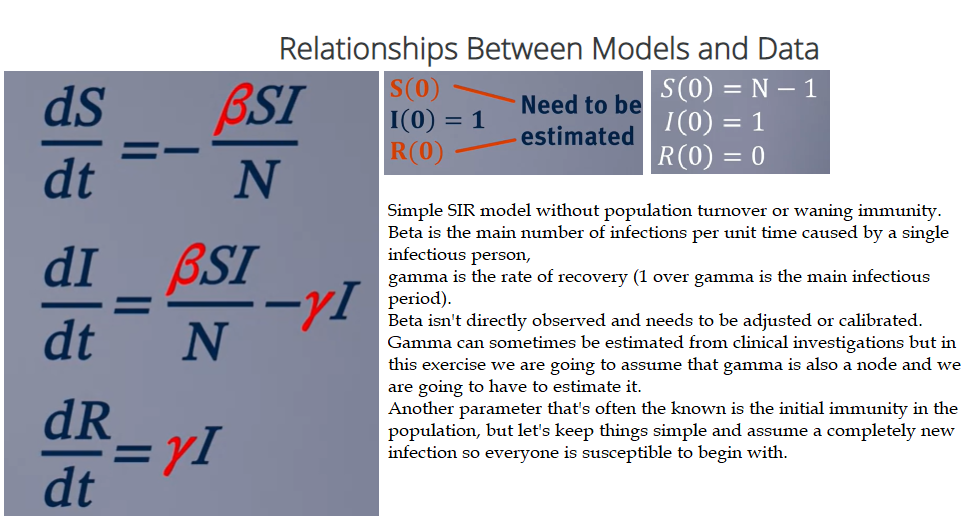
The next step is to make sure that your model is able to capture real-world data. In this exercise you will learn how to do this, with some simple examples. The cell below contains the epidemic data you will be working with, with a column for the time in days, and a column for the prevalence of infection on each day.

### Plot the epidemic curve.

##### Question: Based on the plot, what does the data represent?
This plot represents the number of infected people (Y axis) over time (x axis).


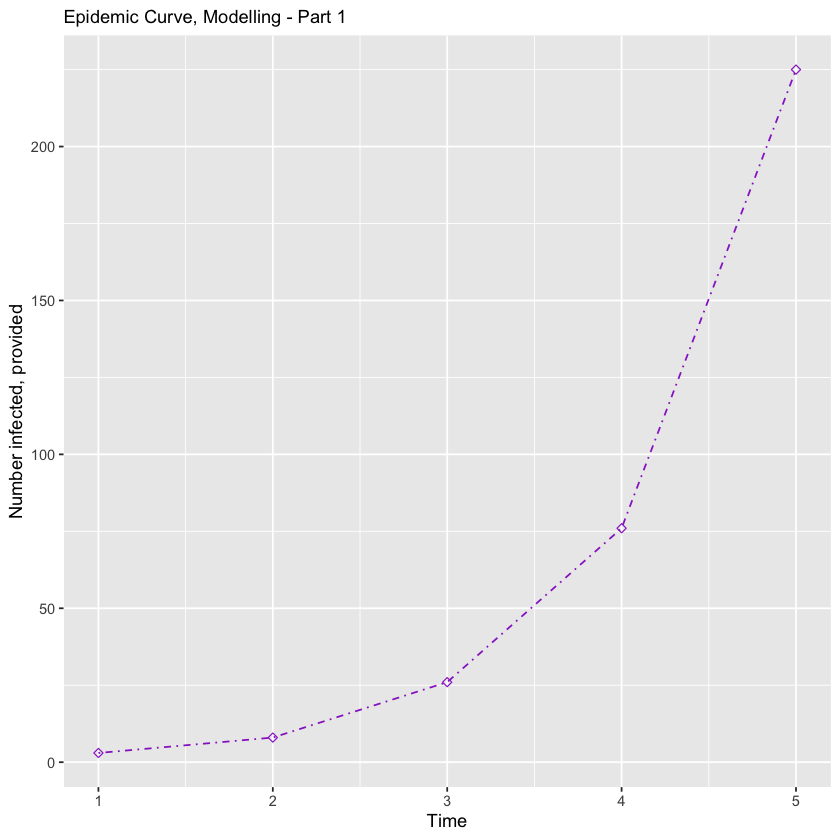

In [134]:
dataprov <- data.frame(time = 1:5,
  number_infected = c(3,8,26,76,225)) 

dataprov %>% 
  select(time, number_infected) %>% 
  ggplot(aes(x=time, y=number_infected)) +
  geom_line(linetype="dotdash", color="darkorchid") +
  geom_point(color="darkorchid", shape=5, show.legend = FALSE) +
  xlab("Time") +
  ylab("Number infected, provided") +
  labs(
    subtitle= "Epidemic Curve, Modelling - Part 1") +
  theme(legend.position="bottom")



#### Question: Based on the code, what is the total size of the population you are modelling? For plotting, which variables in the model output correspond to the variables in the dataset?
The provided code snippet provides for N = 763, where we start with one infected individual. However, the provided dataset used as reference starts with 3 infected persons, so this shall be adjusted on the SIR initial conditions, accordingly.




In [145]:
nicesubtitle <- "SIR Model v1a2 SIR Basic Model, manual calibration"


In [146]:
print("initial state values and parameters")
## [1] "initial state values and parameters"
# MODEL INPUTS:
N        <- 763         # population size
duration <- 6           # total number of days
tsteps   <- 0.1         # chunk into 1 day intervals 
beta     <- 1.1         # infection rate day^-1
gamma    <- 0.1         # recovery rate day^-1
R0 <- beta / gamma

(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  ))  

[1] "initial state values and parameters"


beta gamma    R0 
  1.1   0.1  11.0

In [147]:
initial_state_values <- c(S = N-3,
                          I = 3, 
                          R = 0)
# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 

In [148]:
print("peak infection day when I is at its max: ")
output %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S       I        R        still_Su preval_Inf propor_Re Reff    
1 6    289.131 406.8333 67.03569 37.894   53.32      8.786     4.168337

In [149]:
print("point when R eff goes below 1: ")
output %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S I R still_Su preval_Inf propor_Re Reff

In [150]:
print("last record for the run: ")
output %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S       I        R        still_Su preval_Inf propor_Re Reff    
61 6    289.131 406.8333 67.03569 37.894   53.32      8.786     4.168337

[1] "Plotting the number of people in each compartment over time"


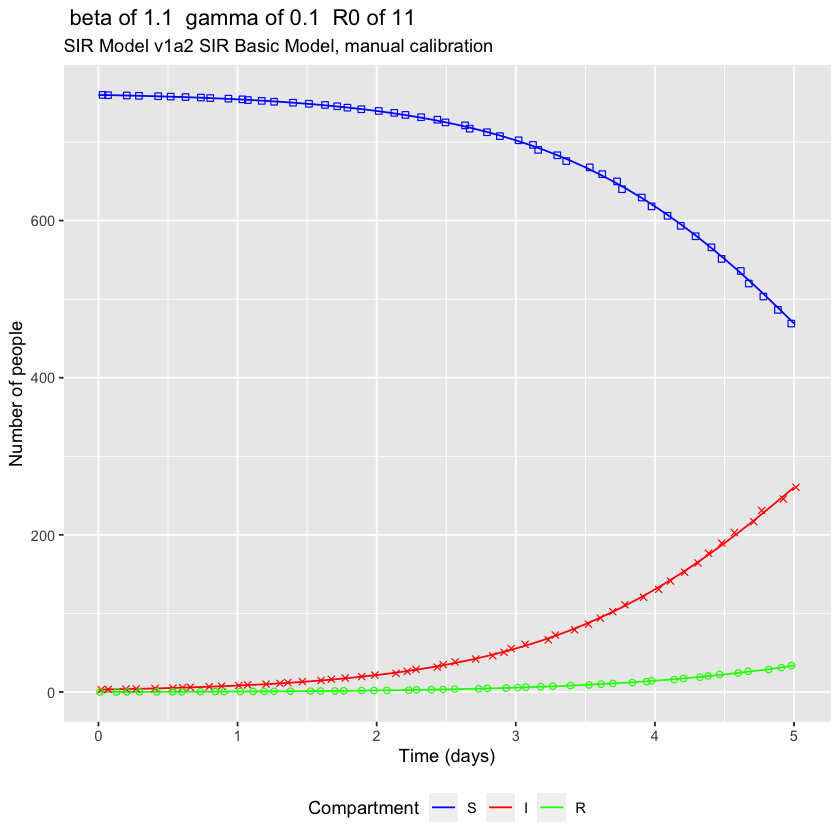

In [151]:
print("Plotting the number of people in each compartment over time")
output %>% 
  filter(time <= 5) %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -Reff) %>% 
  melt(id = "time")  %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green")) + 
  scale_shape_manual(values = c(0,4,1)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  

[1] "Plotting the proportion of people in each compartment over time"


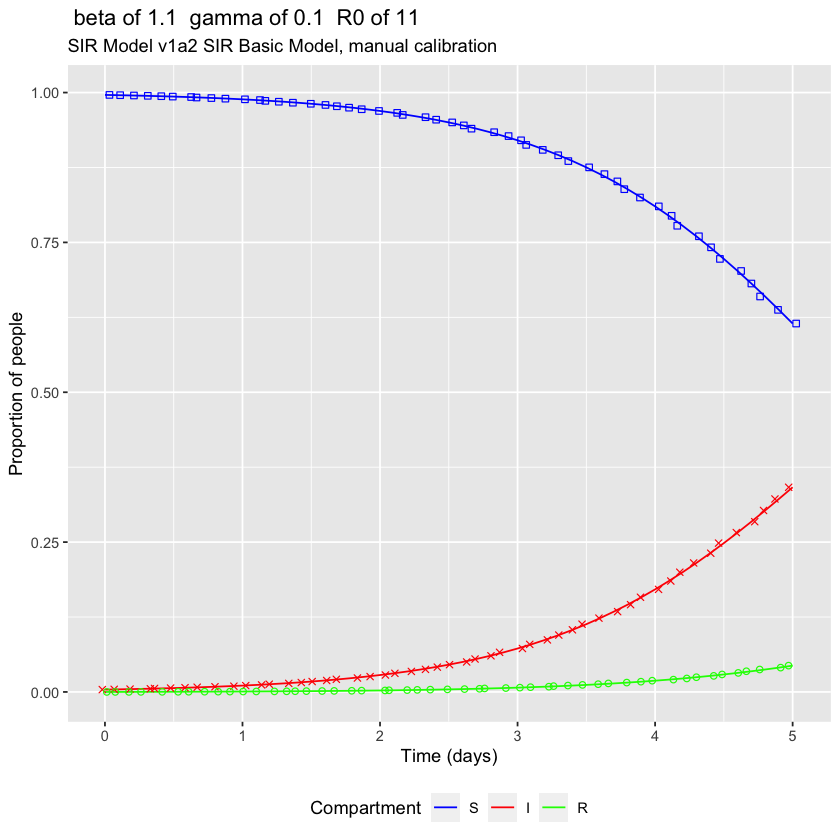

In [152]:
print("Plotting the proportion of people in each compartment over time")
output %>% 
  filter(time <= 5) %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green")) + 
  scale_shape_manual(values = c(0,4,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

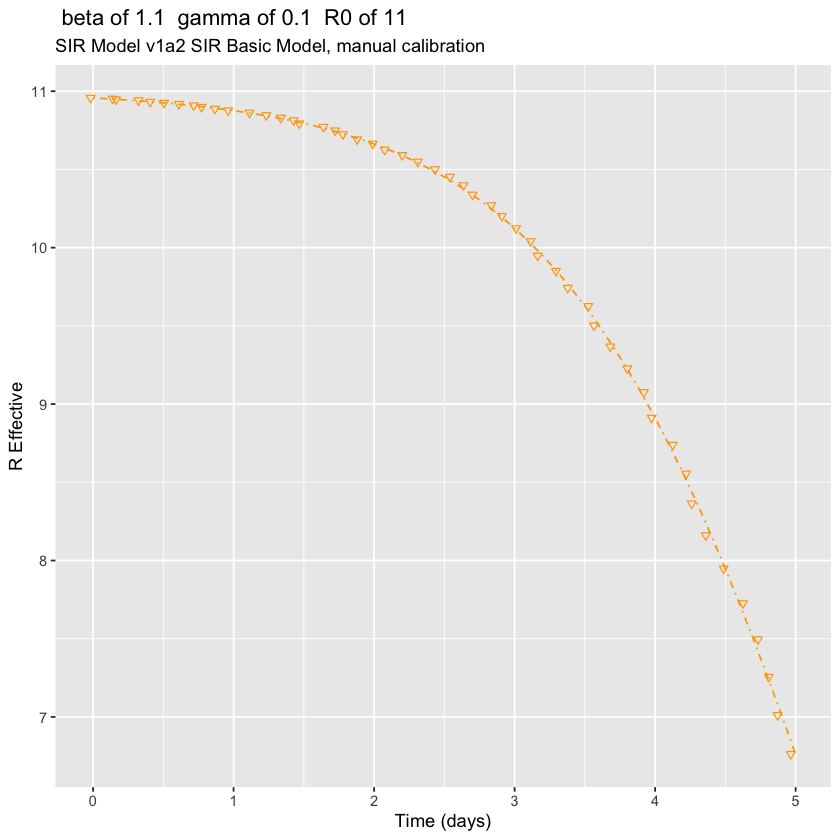

In [153]:
output %>% 
  filter(time <= 5) %>% 
  select(time, Reff) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

Joining, by = "time"


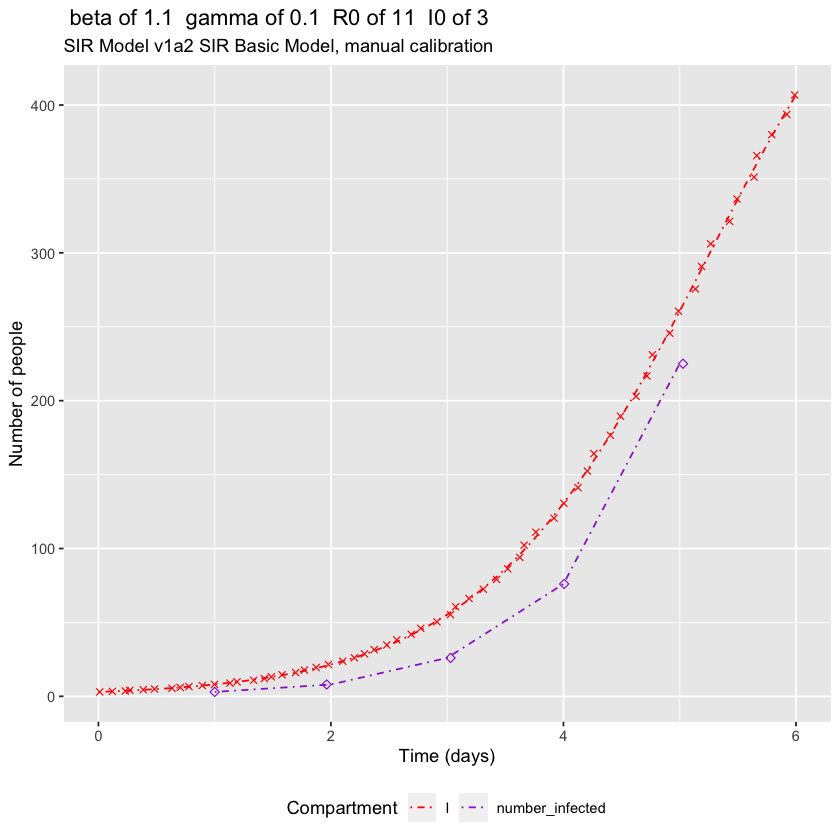

In [154]:
# Compare model I to infection numbers provided
output %>% 
  left_join(dataprov) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " I0 of", initial_state_values['I']),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  

In [155]:
nicesubtitle <- "SIR Model v1a3 SIR Basic Model, manual calibration"

In [156]:
print("Trial-and-error state values and parameters, patch only")
# MODEL INPUTS:
beta     <- 1.2         # infection rate day^-1
gamma    <- 0.2         # recovery rate day^-1
R0 <- beta / gamma
(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  ))  


[1] "Trial-and-error state values and parameters, patch only"


beta gamma    R0 
  1.2   0.2   6.0

Joining, by = "time"


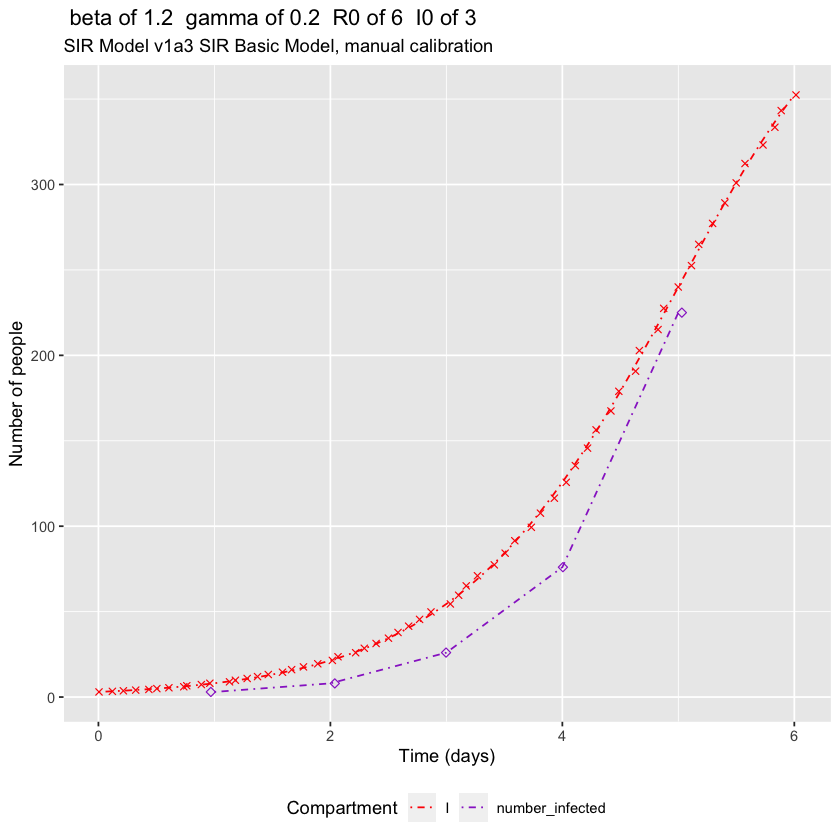

In [157]:
# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 
  
# Compare model I to infection numbers provided
output %>% 
  left_join(dataprov) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " I0 of", initial_state_values['I']),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom") 

In [158]:
nicesubtitle <- "SIR Model v1a4 SIR Basic Model, manual calibration"

In [159]:
print("Trial-and-error state values and parameters, patch only")
# MODEL INPUTS:
beta     <- 0.96        # infection rate day^-1
gamma    <- 0.03        # recovery rate day^-1
R0 <- beta / gamma
(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  ))  

[1] "Trial-and-error state values and parameters, patch only"


beta gamma    R0 
 0.96  0.03 32.00

Joining, by = "time"


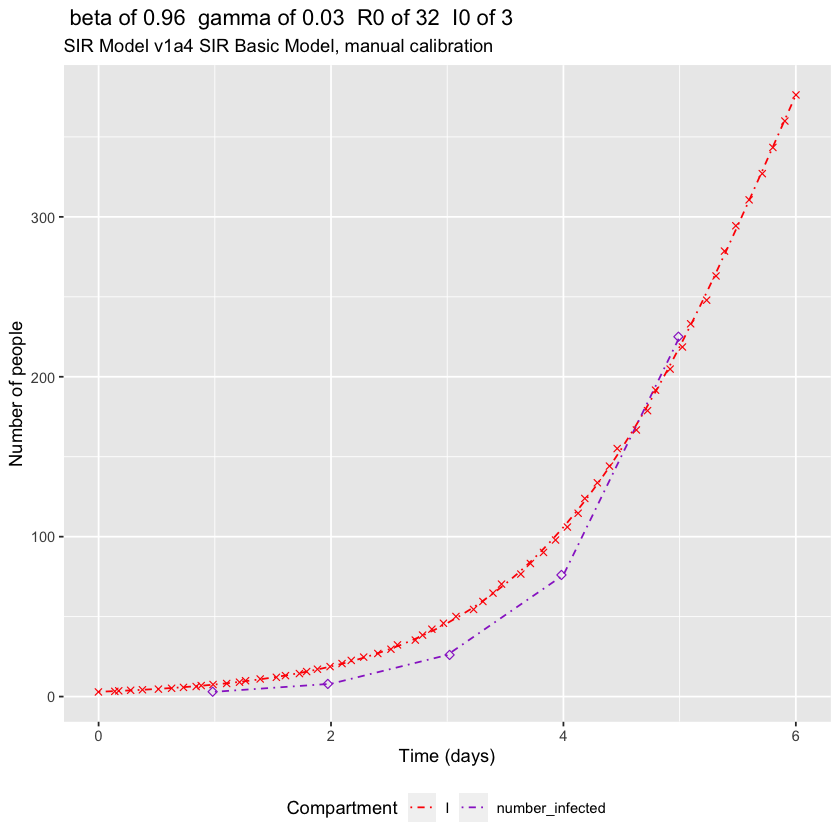

In [160]:
# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 
  
# Compare model I to infection numbers provided
output %>% 
  left_join(dataprov) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " I0 of", initial_state_values['I']),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom") 

Settle back to initial I I0 = 1 to get a different set of values for next exercise.
Using the values of beta β = 1.16 and gamma γ = 0.01.

In [161]:
nicesubtitle <- "SIR Model v1a5 SIR Basic Model, manual calibration, diff Init Values"



In [162]:
print("Trial-and-error state values and parameters, patch only")
initial_state_values <- c(S = N-1,
                          I = 1, 
                          R = 0)
# MODEL INPUTS:
beta     <- 1.16        # infection rate day^-1
gamma    <- 0.01        # recovery rate day^-1
R0 <- beta / gamma
(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  ))  

[1] "Trial-and-error state values and parameters, patch only"


beta  gamma     R0 
  1.16   0.01 116.00

Joining, by = "time"


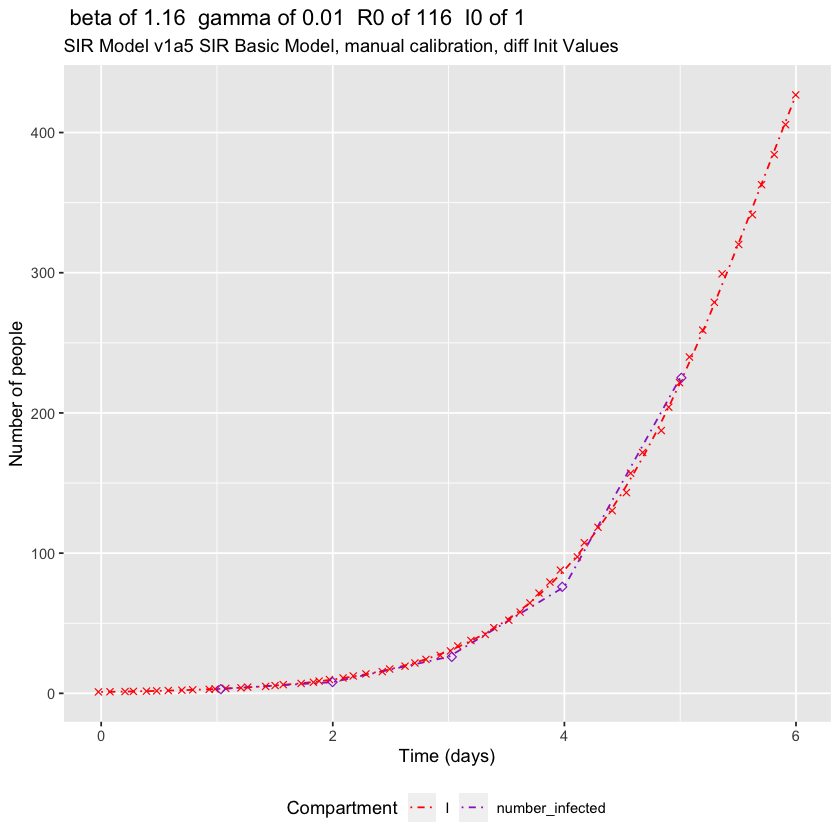

In [163]:
# MODEL OUTPUT (solving the differential equations):
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 
  
# Compare model I to infection numbers provided
output %>% 
  left_join(dataprov) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " I0 of", initial_state_values['I']),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  

### Manual calibration of an SIR model (part 2)
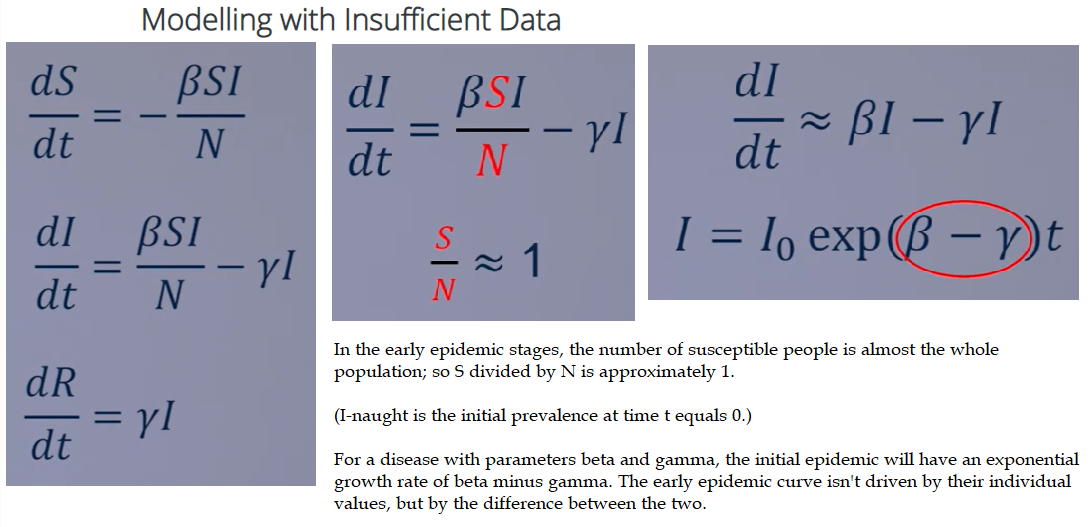


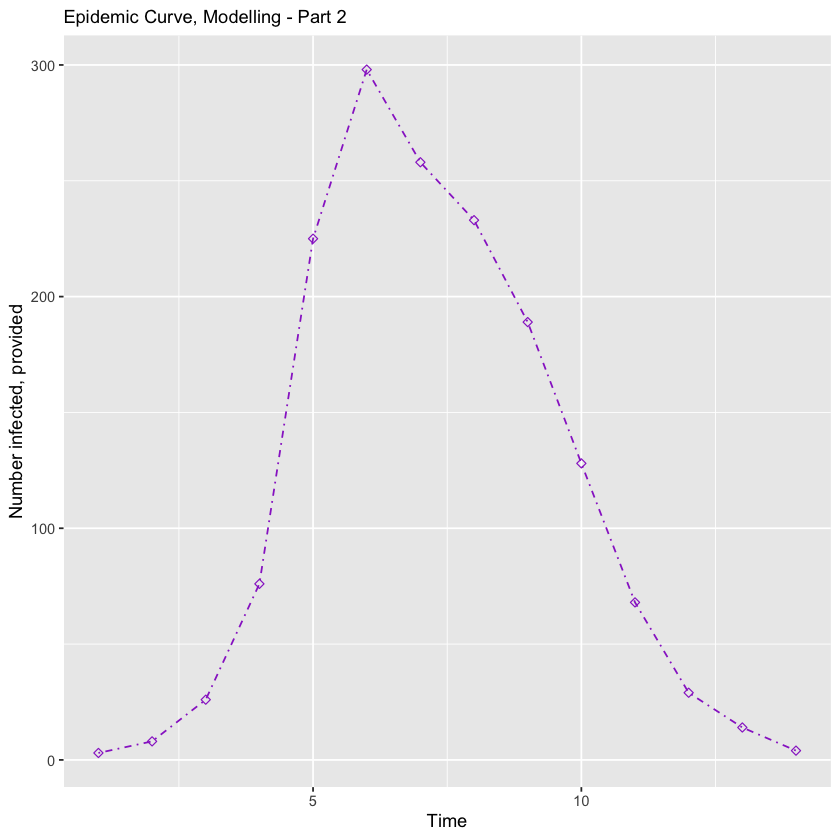

In [164]:
dataprov2 <-  data.frame(time = 1:14, 
number_infected =  c(3,8,26,76,225,298,258,233,189,128,68,29,14,4))

dataprov2 %>% 
  select(time, number_infected) %>% 
  ggplot(aes(x=time, y=number_infected)) +
  geom_line(linetype="dotdash", color="darkorchid") +
  geom_point(color="darkorchid", shape=5, show.legend = FALSE) +
  xlab("Time") +
  ylab("Number infected, provided") +
  labs(
    subtitle= "Epidemic Curve, Modelling - Part 2") +
  theme(legend.position="bottom")

In [165]:
nicesubtitle <- "SIR Model v1a6 SIR Basic Model, manual calibration"

In [166]:
print("initial state values and parameters")
## [1] "initial state values and parameters"
# MODEL INPUTS:
N        <- 763         # population size
duration <- 14          # total number of days
tsteps   <- 0.2         # chunk into 1 day intervals 
beta     <- 1.16        # infection rate day^-1
gamma    <- 0.01        # recovery rate day^-1
R0 <- beta / gamma

(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  )) 

[1] "initial state values and parameters"


beta  gamma     R0 
  1.16   0.01 116.00

In [167]:
initial_state_values <- c(S = N-1,
                          I = 1, 
                          R = 0)
# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output2 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 

In [168]:
print("peak infection day when I is at its max: ")
output2 %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


time S        I        R        still_Su preval_Inf propor_Re Reff     
1 10   6.286704 725.1572 31.55605 0.824    95.04      4.136     0.9557768

In [169]:
print("point when R eff goes below 1: ")
output2 %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


time S        I        R        still_Su preval_Inf propor_Re Reff     
1 10   6.286704 725.1572 31.55605 0.824    95.04      4.136     0.9557768

In [170]:
print("last record for the run: ")
## [1] "last record for the run: "
output2 %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


time S          I        R        still_Su preval_Inf propor_Re Reff      
71 14   0.08098028 702.7374 60.18159 0.011    92.102     7.887     0.01231155

[1] "Plotting the number of people in each compartment over time"


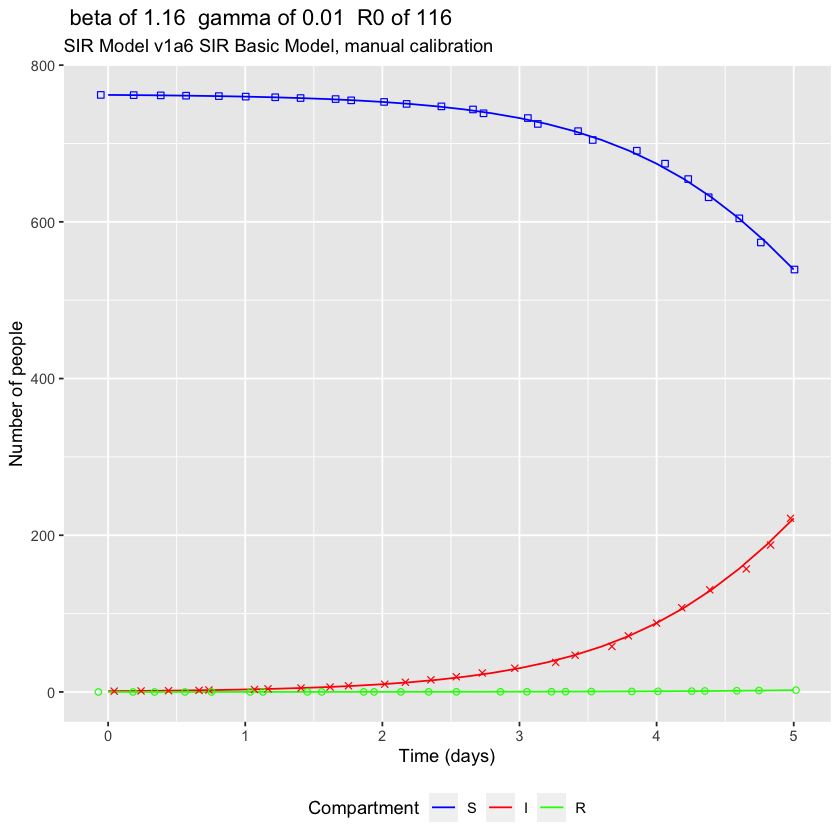

In [171]:
print("Plotting the number of people in each compartment over time")
output2 %>% 
  filter(time <= 5) %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -Reff) %>% 
  melt(id = "time")  %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green")) + 
  scale_shape_manual(values = c(0,4,1)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom") 

[1] "Plotting the proportion of people in each compartment over time"


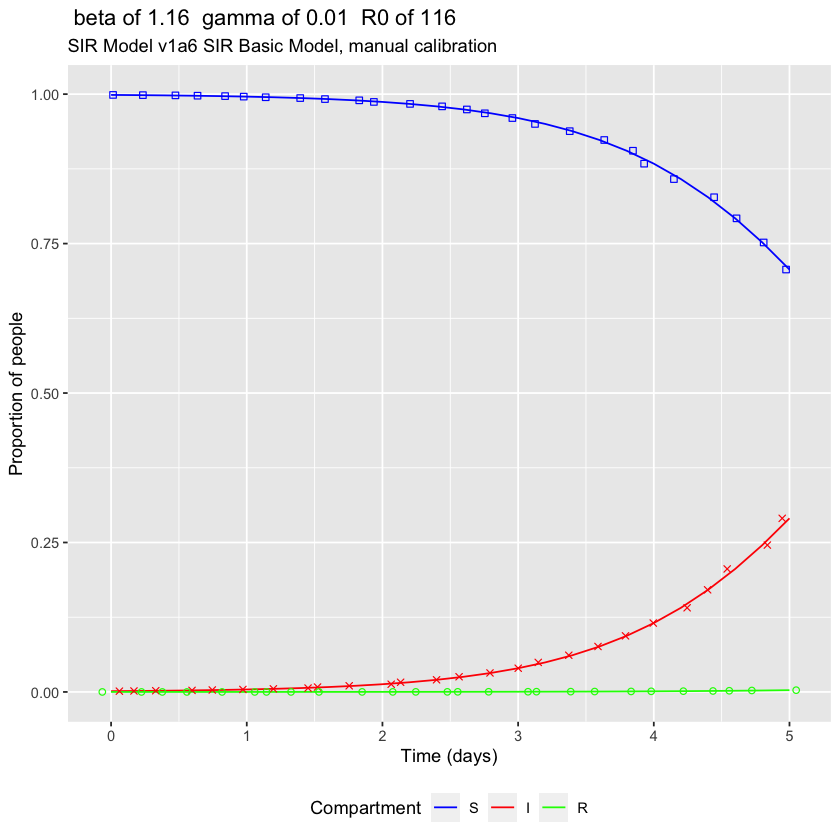

In [173]:
print("Plotting the proportion of people in each compartment over time")
output2 %>% 
  filter(time <= 5) %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green")) + 
  scale_shape_manual(values = c(0,4,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

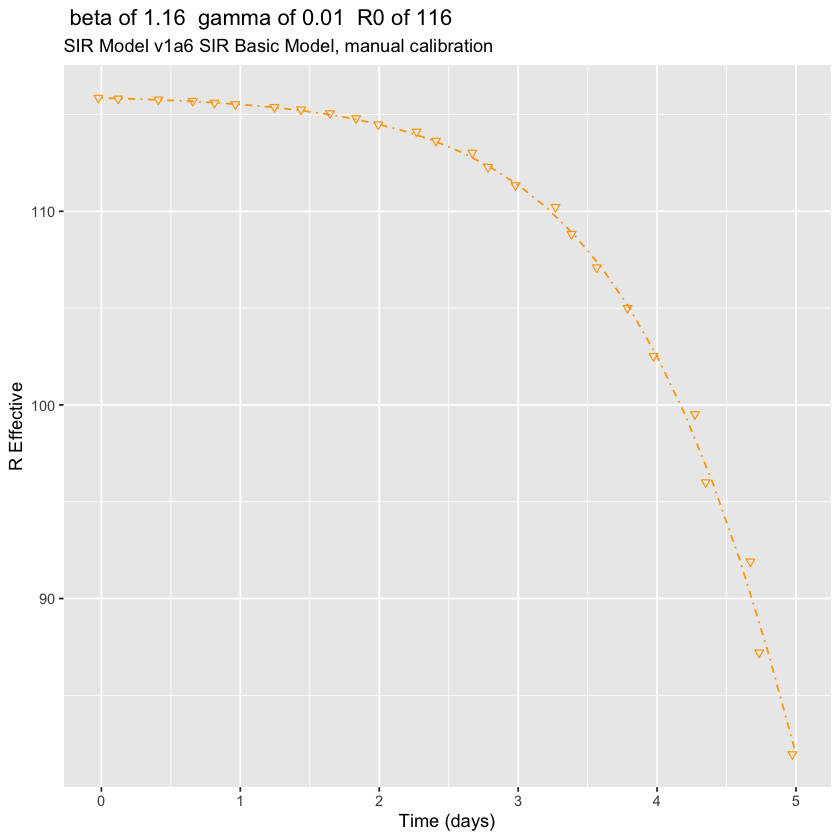

In [174]:
output2 %>% 
  filter(time <= 5) %>% 
  select(time, Reff) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

Joining, by = "time"


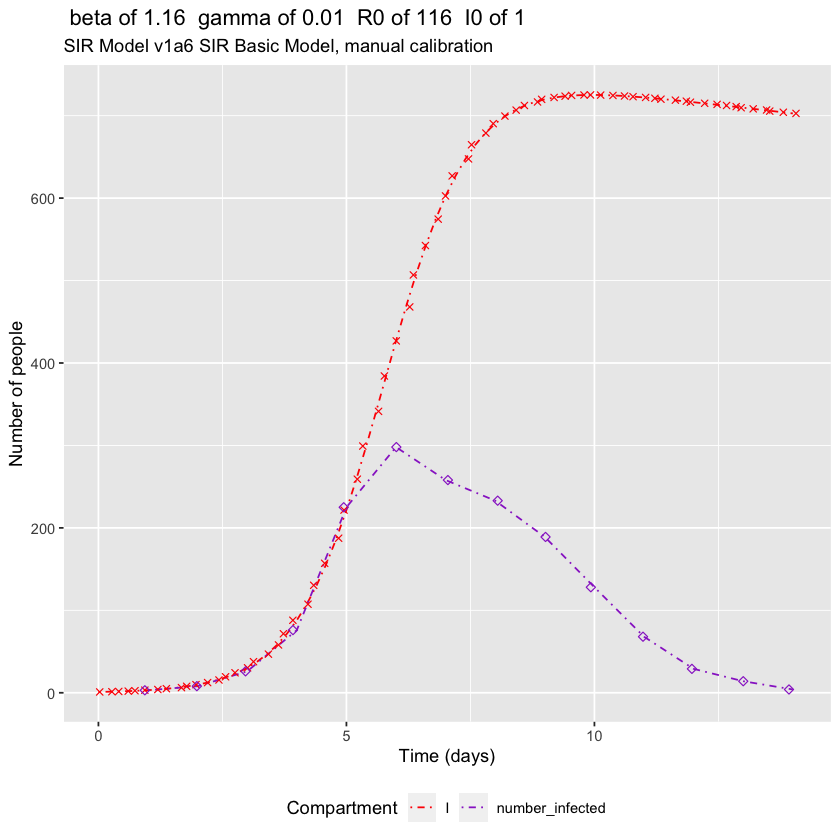

In [176]:
# Compare model I to infection numbers provided
output2 %>% 
  left_join(dataprov2) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " I0 of", initial_state_values['I']),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  

In [177]:
nicesubtitle <- "SIR Model v1a7 SIR Basic Model, manual calibration"

In [178]:
print("Trial-and-error state values and parameters, patch only")
# MODEL INPUTS:
beta     <- 1.72        # infection rate day^-1
gamma    <- 0.43        # recovery rate day^-1
R0 <- beta / gamma
(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  ))  

[1] "Trial-and-error state values and parameters, patch only"


beta gamma    R0 
 1.72  0.43  4.00

Joining, by = "time"


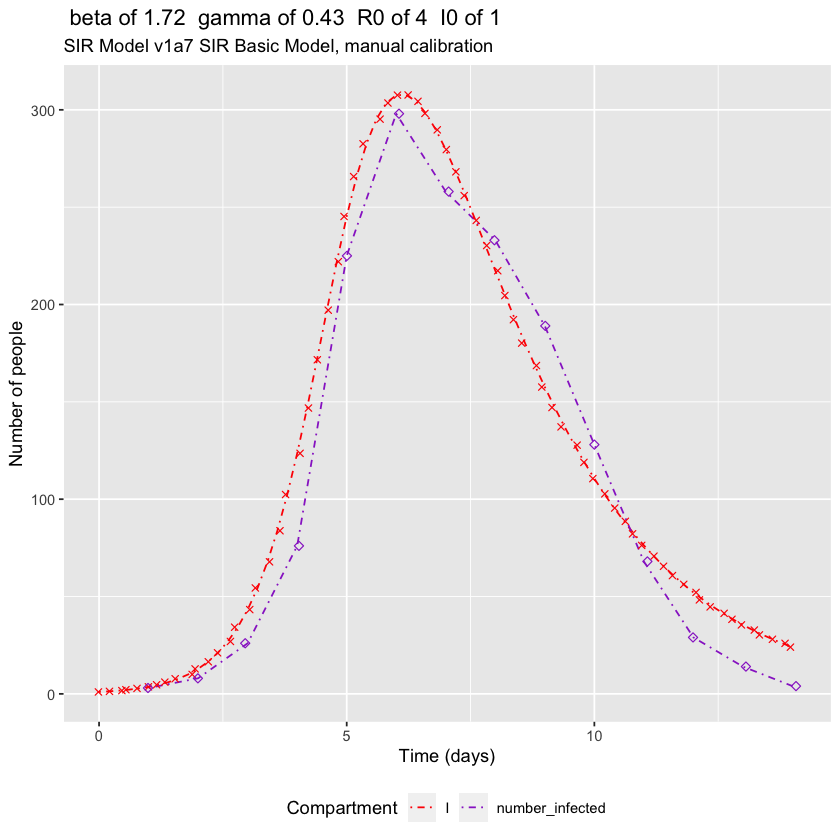

In [179]:
# MODEL OUTPUT (solving the differential equations):
output2 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 
  
# Compare model I to infection numbers provided
output2 %>% 
  left_join(dataprov2) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " I0 of", initial_state_values['I']),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  

Provided solution uses β = 1.70 and γ = 0.45

In [180]:
nicesubtitle <- "SIR Model v1a8 SIR Basic Model, manual calibration"

In [181]:
print("Trial-and-error state values and parameters, patch only")
# MODEL INPUTS:
beta     <- 1.70        # infection rate day^-1
gamma    <- 0.45        # recovery rate day^-1
R0 <- beta / gamma
(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  ))  

[1] "Trial-and-error state values and parameters, patch only"


beta    gamma       R0 
1.700000 0.450000 3.777778

Joining, by = "time"


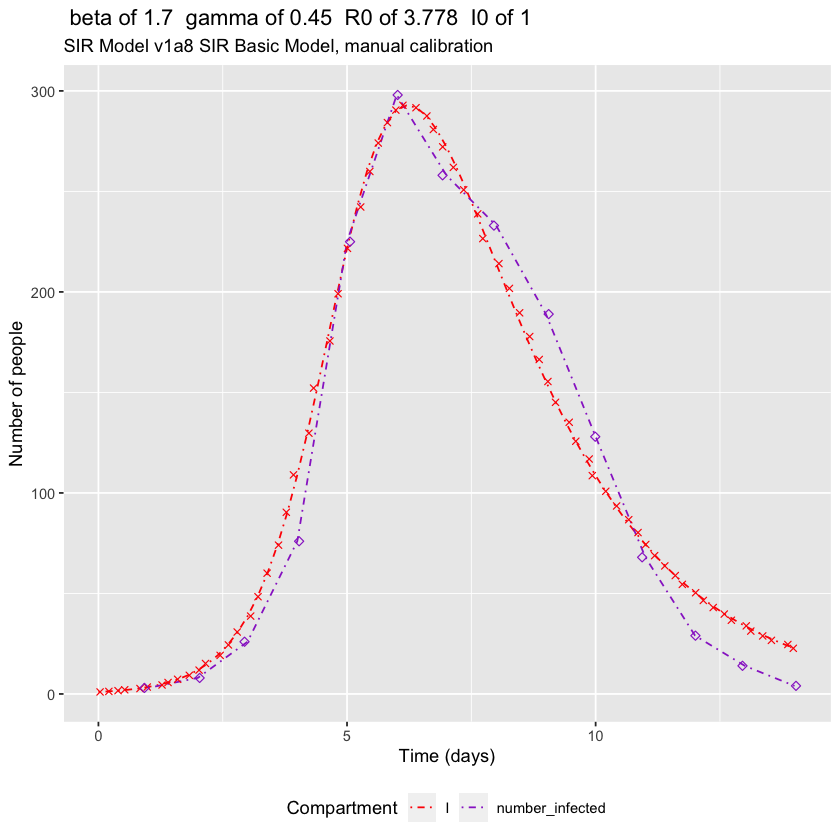

In [182]:
# MODEL OUTPUT (solving the differential equations):
output2 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 
  
# Compare model I to infection numbers provided
output2 %>% 
  left_join(dataprov2) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3),
    " I0 of", initial_state_values['I']),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  

### Writing a sum-of-squares function in R, for SIR model fits
Introduction
When you are trying to fit a model to data, you use a distance function to assess, quantitatively how “far” the model is from the data. By calculating the output of this function for a range of parameter sets, you can find which of those parameter sets generates the model which is the closest fit to the data.

You can calculate the value of the distance function by hand for each model you try - but because this means doing the same calculation repeatedly with different inputs, this is a good task for which using a function would be efficient.

So here, you will create a function yourself, to

calculate and return the sum-of-squares value (SSQ) for the fit of a simple SIR model, parameterised with given values of β and γ, to any dataset.

use this function to find the sum-of-squares of models fit to a simple datset (the flu dataset you may have used in other activities), with the following parameters:

β = 1.15, γ = 0.02
β = 1.7, γ = 0.45
β = 1.9, γ = 0.6
Put very simply, your function will have this structure

In [183]:
SIR_SSQ <- function(arguments) { ### fill in your arguments
    
    # Calculate model output
    ### YOUR CODE HERE ###
    
    # Calculate sum-of-squares (SSQ) of model fit
    ### YOUR CODE HERE ###

    return(SSQ)

}

In [184]:
# SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# SSQ FUNCTION (assumes sir_model model already loaded)
# parameters - vector with named elements for sir_model
# idat - df or list containing vectors number_infected (I) and time
SIR_SSQ <- function(parameters, idat) {  
# MODEL OUTPUT (solving the differential equations):
oderesult <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))
# sum-of-squares (SSQ) of model fit requires idat
idat <- na.omit(idat)
deltas2 <- (oderesult$I[oderesult$time %in% idat$time] - idat$number_infected)^2
SSQ   <- sum(deltas2)
return(SSQ)
}

## load data 
flu_data <- data.frame(time = 1:14,
                   number_infected = c(3,8,26,76,225,298,258,233,189,128,68,29,14,4))
initial_state_values <- c(S = 762, I = 1, R = 0)

## calculate the sum-of-squares for an SIR model fit to these data where:
### beta = 1.15, gamma = 0.02  
### beta = 1.7,  gamma = 0.45  
### beta = 1.9,  gamma = 0.6  

# populate time for 14 days, dense
times <- seq(from = 0, to = 14, by = 0.1) 

# test 1 with beta and gamma in a vector 'parms'
parms <- c(beta = 1.15, gamma = 0.02)

ssq1 <- SIR_SSQ(parameters = parms, 
  idat = flu_data)
print(paste0("ssq = ", ssq1, ", where beta = ", parms['beta'], ", gamma = ", parms['gamma']))

[1] "ssq = 2507764.33057048, where beta = 1.15, gamma = 0.02"


In [185]:
# test 2 with a beta and gamma entered in function
ssq2 <- SIR_SSQ(parameters =c(beta =1.7, gamma =0.45), 
  idat =flu_data)
print(paste0("ssq = ", ssq2, ", where beta = 1.7, gamma = 0.45"))

[1] "ssq = 4630.30225929158, where beta = 1.7, gamma = 0.45"


In [186]:
# test 3 with beta and gamma in a vector 'parms'
parms <- c(beta = 1.9, gamma = 0.6)

ssq3 <- SIR_SSQ(parameters = parms, 
  idat = flu_data)
print(paste0("ssq = ", ssq3, ", where beta = ", parms['beta'], ", gamma = ", parms['gamma']))

[1] "ssq = 34243.6805666932, where beta = 1.9, gamma = 0.6"


### Further work:
Modify your SSQ function so it would take in any type of model equation into the ode() function:



In [187]:
#SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# SSQ FUNCTION (assumes sir_model model already loaded)
# parameters - vector with named elements for sir_model
# idat - df or list containing vectors number_infected (I) and time
SIR_SSQv2 <- function(func, parameters, idat) {  
# MODEL OUTPUT (solving the differential equations):
oderesult <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = func,
                            parms = parameters))
# sum-of-squares (SSQ) of model fit requires idat
idat <- na.omit(idat)
deltas2 <- (oderesult$I[oderesult$time %in% idat$time] - idat$number_infected)^2
SSQ   <- sum(deltas2)
return(SSQ)
}

## load data 
flu_data <- data.frame(time = 1:14,
                   number_infected = c(3,8,26,76,225,298,258,233,189,128,68,29,14,4))
initial_state_values <- c(S = 762, I = 1, R = 0)

## calculate the sum-of-squares for an SIR model fit to these data where:
### beta = 1.15, gamma = 0.02  
### beta = 1.7,  gamma = 0.45  
### beta = 1.9,  gamma = 0.6  

# populate time for 14 days, dense
times <- seq(from = 0, to = 14, by = 0.1) 

# test 1 with beta and gamma in a vector 'parms'
parms <- c(beta = 1.15, gamma = 0.02)

ssq1 <- SIR_SSQv2(func = sir_model, 
  parameters = parms, 
  idat = flu_data)
print(paste0("ssq = ", ssq1, ", where beta = ", parms['beta'], ", gamma = ", parms['gamma']))

[1] "ssq = 2507764.33057048, where beta = 1.15, gamma = 0.02"


In [188]:
# test 2 with a beta and gamma entered in function
ssq2 <- SIR_SSQv2(func = sir_model,
  parameters =c(beta =1.7, gamma =0.45),
  idat =flu_data)
print(paste0("ssq = ", ssq2, ", where beta = 1.7, gamma = 0.45"))


[1] "ssq = 4630.30225929158, where beta = 1.7, gamma = 0.45"


In [189]:
# test 3 with beta and gamma in a vector 'parms'
parms <- c(beta = 1.9, gamma = 0.6)

ssq3 <- SIR_SSQv2(func = sir_model,
  parameters = parms,
  idat = flu_data)
print(paste0("ssq = ", ssq3, ", where beta = ", parms['beta'], ", gamma = ", parms['gamma']))


[1] "ssq = 34243.6805666932, where beta = 1.9, gamma = 0.6"


### Automated least-squares calibration: Using optim(), R’s built-in optimisation function
### Introduction

    Use optim() to find the beta and gamma for the best SIR model to fit an example dataset
    Plot the example dataset against your “best fit” model


In [190]:
# SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# SSQ FUNCTION (assumes sir_model model already loaded)
# parameters - vector with named elements for sir_model
# idat - df or list containing vectors number_infected (I) and time
SIR_SSQv2 <- function(func, parameters, idat) {  
# MODEL OUTPUT (solving the differential equations):
oderesult <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = func,
                            parms = parameters))
# sum-of-squares (SSQ) of model fit requires idat
idat <- na.omit(idat)
deltas2 <- (oderesult$I[oderesult$time %in% idat$time] - idat$number_infected)^2
SSQ   <- sum(deltas2)
return(SSQ)
}

## load data 
flu_data <- data.frame(time = 1:14,
                   number_infected = c(3,8,26,76,225,298,258,233,189,128,68,29,14,4))
initial_state_values <- c(S = 762, I = 1, R = 0)

## calculate the sum-of-squares for an SIR model fit to these data where:
### beta = 1.15, gamma = 0.02  

# populate time for 14 days, dense
times <- seq(from = 0, to = 14, by = 0.1) 

# test 1 with beta and gamma in a vector 'parms'
parms <- c(beta = 1.15, gamma = 0.02)

ssq1 <- SIR_SSQv2(func = sir_model, 
  parameters = parms, 
  idat = flu_data)
print(paste0("ssq = ", ssq1, ", where beta = ", parms['beta'], ", gamma = ", parms['gamma']))


[1] "ssq = 2507764.33057048, where beta = 1.15, gamma = 0.02"


In [191]:
# choose values to start your optimisation
beta_start  <- 1
gamma_start <- 0.5

# run optim
(optimised <- optim(par = c(beta = beta_start
                  , gamma = gamma_start)
                  , fn  = SIR_SSQv2
                  , func = sir_model
                  , idat = flu_data
  ))

$par
     beta     gamma 
1.6692280 0.4434254 

$value
[1] 4121.945

$counts
function gradient 
      67       NA 

$convergence
[1] 0

$message
NULL

In [192]:
# examine optim() output and plot "best" model against example dataset
opt_mod <- as.data.frame(ode(y = initial_state_values  # named vector of initial state values
                  , times = times         # vector of times
                  , func = sir_model      # your predefined SIR function
                  , parms = optimised$par
  ))

nicesubtitle <- "Automated Least-Squares Calibration: Using optim() c2w3_2"

Joining, by = "time"


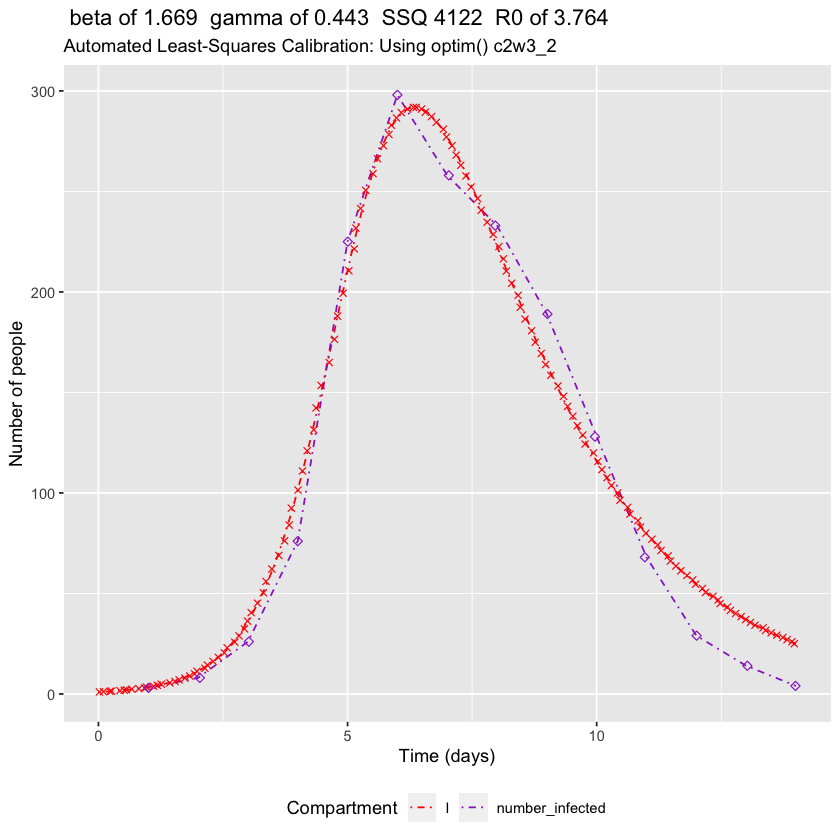

In [193]:
# Compare model I to infection numbers provided
opt_mod %>% 
  left_join(flu_data) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", round(optimised$par[1],3),
    " gamma of", round(optimised$par[2],3),
    " SSQ", round(optimised$value,0),
    " R0 of", round(optimised$par[1]/optimised$par[2],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom") 

In [197]:
dataprov3 <- read.csv("m3_nb3_data.csv")

dataprov3 %>% 
  select(time, number_infected) %>% 
  ggplot(aes(x=time, y=number_infected)) +
  geom_line(linetype="dotdash", color="darkorchid") +
  geom_point(color="darkorchid", shape=5, show.legend = FALSE) +
  xlab("Time") +
  ylab("Number infected, provided") +
  labs(
    subtitle= "Epidemic Curve, Modelling - c2w3_3") +
  theme(legend.position="bottom")

Warning message in file(file, "rt"):
“cannot open file 'm3_nb3_data.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection
